## K-S Beating

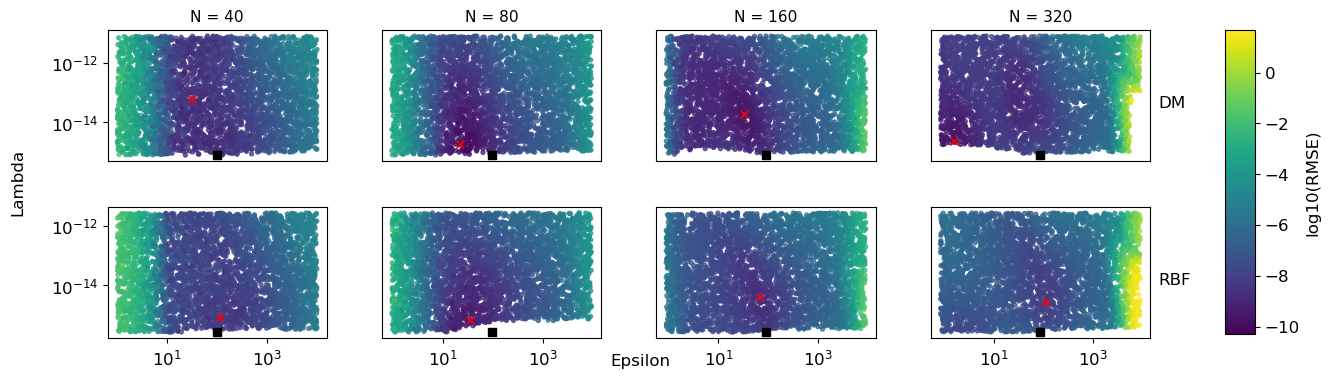

In [ ]:
import os
import numpy as np
import polars as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator

# ---------------------------
# Config
# ---------------------------
devices = 4
modes = ["diffusion", "rbf"]
mode_labels = {"diffusion": "DM", "rbf": "RBF"}
num_points_lst = [40, 80, 160, 320]
map_type = "skip-connection"
dt = 0.01
plt.rcParams.update({"font.size": 12})

# ---------------------------
# 1) Pre-pass: find global vmin/vmax on log10(RMSE)
# ---------------------------
global_min = np.inf
global_max = -np.inf
existing = {}  # cache: (mode, d, num_points) -> DataFrame

for mode in modes:
    for num_points in num_points_lst:
        fname = f"./numerical_results/ks_beat_cv_{mode}_{num_points}_{map_type}_no_proj_fully_scaled.parquet"
        if not os.path.exists(fname):
            continue
        df = pl.read_parquet(fname)
        existing[(mode, num_points)] = df

        rmse = df["rmse"].to_numpy()
        mask = np.isfinite(rmse) & (rmse > 0)
        if not np.any(mask):
            continue
        log_rmse = np.log10(rmse[mask])
        global_min = min(global_min, np.nanmin(log_rmse))
        global_max = max(global_max, np.nanmax(log_rmse))

if not np.isfinite(global_min) or not np.isfinite(global_max):
    raise RuntimeError("No valid RMSE values > 0 found across the provided parquet files.")

# ---------------------------
# 2) Plot with per-subplot domains (no shared axes)
# ---------------------------
nrows = len(modes)
ncols = len(num_points_lst)

fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(15, 4),
    sharex=False, sharey=False
)

# Leave a bit more room on the right for the colorbar
fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)

norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)
cmap = "viridis"

for i_mode, mode in enumerate(modes):
    row = i_mode
    for j, num_points in enumerate(num_points_lst):
        ax = axs[row, j]

        key = (mode, num_points)
        if key not in existing:
            ax.set_visible(False)
            continue

        cv_results = existing[key]
        eps   = cv_results["epsilon"].to_numpy()
        lam   = cv_results["lambda"].to_numpy()   # linear scale
        eps_c = cv_results["epsilon_c"].to_numpy()[0]
        lam_m = cv_results["lambda_min"].to_numpy()[0]  # log10(lambda*)
        rmse  = cv_results["rmse"].to_numpy()

        mask = (
            np.isfinite(rmse) & (rmse > 0) &
            np.isfinite(eps)  & (eps  > 0) &
            np.isfinite(lam)  & (lam  > 0)
        )
        if not np.any(mask):
            ax.set_visible(False)
            continue

        ax.scatter(
            eps[mask],
            lam[mask],
            c=np.log10(rmse[mask]),
            cmap=cmap,
            norm=norm,
            s=8,
            alpha=0.75,
        )

        # mark best in this grid
        idx = np.nanargmin(rmse[mask])
        ax.scatter([eps[mask][idx]], [lam[mask][idx]], c="red", marker="x", s=30, linewidths=1.2)
        ax.scatter(eps_c, 10**lam_m, c="black", marker='s', s=30)

        ax.set_xscale("log")
        ax.set_yscale("log")

        # per-subplot limits (you set fixed domains; keep them)
        # ax.set_xlim([10**(-3), 10**(3)])
        # ax.set_ylim([10**(-14.5), 10**(-8)])

        # column titles
        if row == 0:
            ax.set_title(f"N = {num_points}", fontsize=11)

        # row labels on the right (as in your original)
        if j == ncols - 1:
            ax.set_ylabel(f"{mode_labels[mode]}", rotation=0, labelpad=6, ha="left")
            ax.yaxis.set_label_position("right")

# ---------------------------
# Colorbar (position tied to subplot area)
# ---------------------------
x0 = fig.subplotpars.right + 0.05  # 0.02 = gap from subplots
cbar_ax = fig.add_axes([x0, 0.12, 0.02, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel("log10(RMSE)")

# ---------------------------
# Global axis labels
# ---------------------------
fig.text(0.48, 0.04, "Epsilon", ha="center")
fig.text(0.06, 0.5, "Lambda", va="center", rotation="vertical")

# ---------------------------
# Ticks: bottom-row x ticks & leftmost-column y ticks, sparse
# ---------------------------
# Hide everywhere first
for ax in axs.flat:
    ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False, top=False, labeltop=False)
    ax.tick_params(axis="y", which="both", left=False,  labelleft=False,  right=False, labelright=False)
    ax.minorticks_off()

# sparse locators
x_locator = LogLocator(base=10, numticks=3)  # adjust numticks to taste
y_locator = LogLocator(base=10, numticks=3)

# Enable y on leftmost column
for r in range(nrows):
    ax = axs[r, 0]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

# Enable x on bottom row
for c in range(ncols):
    ax = axs[nrows - 1, c]
    ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
    ax.xaxis.set_major_locator(x_locator)

fig.savefig("./pics/ks_beating_cv_results.pdf", bbox_inches="tight", dpi=500)


Manifold info:
    No. of data points: 39
    No. of ambient dim: 64
    Estimated intrinsic dim: 1/1.1783701496668386
2**res.x * dmx = 77.26715147980453
    Reference bandwidth 0.625214041085048; ref L2 dist 294.34109591575157; ref scalar 0.26250888018002244
Manifold info:
    No. of data points: 79
    No. of ambient dim: 64
    Estimated intrinsic dim: 1/1.1938807202790003
2**res.x * dmx = 75.59687804608453
    Reference bandwidth 0.5851450389714945; ref L2 dist 289.91624890394144; ref scalar 0.2607541948127654
Manifold info:
    No. of data points: 159
    No. of ambient dim: 64
    Estimated intrinsic dim: 1/1.2081044435365524
2**res.x * dmx = 75.1243572850557
    Reference bandwidth 0.5578076076301249; ref L2 dist 274.0913988739853; ref scalar 0.27408505919441284
Manifold info:
    No. of data points: 319
    No. of ambient dim: 64
    Estimated intrinsic dim: 1/1.2196784961830156
2**res.x * dmx = 74.87561987805265
    Reference bandwidth 0.5377366255987258; ref L2 dist 273.19307

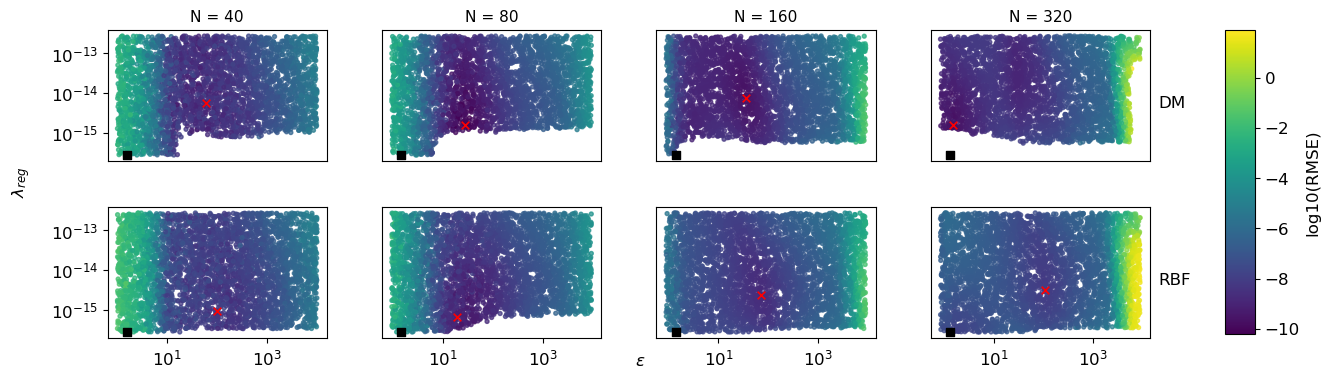

In [ ]:
import os
import numpy as np
import polars as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import pickle
from gindy.src.manifold import Manifold

def load_data():
    
    NT = 5000000
    DT = 0.0001
    TS = 100
    data = pickle.load(open(f"./ks_utils/ksdata_beating_NT_{NT}_dt_{DT}_ts_{TS}.pkl", "rb"))
    dt = data["dt"]
    nu = data["nu"]
    xx = data["x"]
    tt = data["t"]
    uu = data["udata"].astype(np.float64)
    # print(uu.shape)
    Nx, Nt = len(xx), len(tt)
    assert uu.shape == (Nt, Nx)

    data_train = uu[:num_points]

    # mean = np.array([0])
    # std = np.array([1]) 

    mean = np.mean(data_train, axis=0)
    std = np.std(data_train, axis=0)
    data_train = (data_train - mean) / std

    data_train_x = data_train[:-1]
    data_train_y = data_train[1:]

    # data_val = uu[num_points : num_points + validation_repeats * validation_horizon]
    data_val = uu[:num_points] #uu[:validation_repeats * validation_horizon]
    data_val = (data_val - mean) / std

    data_test = []
    start0 = num_points + validation_repeats * validation_horizon
    for _ in range(test_trials):
        s = start0 + _ * steps
        e = s + steps
        data_test.append([(uu[s:e] - mean) / std])

    return dt, data_train_x, data_train_y, data_val, data_test, mean, std

devices = 4
validation_repeats = 1
modes = ["diffusion", "rbf"]
mode_labels = {"diffusion": "DM", "rbf": "RBF"}
num_points_lst = [40, 80, 160, 320]
map_type = "skip-connection"
dt = 0.01
test_trials = 32
steps = 500
plt.rcParams.update({"font.size": 12})


# ---------------------------
# 1) Pre-pass: find global vmin/vmax on log10(RMSE)
# ---------------------------
global_min = np.inf
global_max = -np.inf
existing = {}  # cache: (mode, d, num_points) -> DataFrame

for mode in modes:
    for num_points in num_points_lst:
        fname = f"./numerical_results/ks_beat_cv_{mode}_{num_points}_{map_type}_no_proj_fully_scaled.parquet"
        if not os.path.exists(fname):
            continue
        df = pl.read_parquet(fname)
        existing[(mode, num_points)] = df

        rmse = df["rmse"].to_numpy()
        mask = np.isfinite(rmse) & (rmse > 0)
        if not np.any(mask):
            continue
        log_rmse = np.log10(rmse[mask])
        global_min = min(global_min, np.nanmin(log_rmse))
        global_max = max(global_max, np.nanmax(log_rmse))

if not np.isfinite(global_min) or not np.isfinite(global_max):
    raise RuntimeError("No valid RMSE values > 0 found across the provided parquet files.")

# ---------------------------
# 2) Plot with per-subplot domains (no shared axes)
# ---------------------------
nrows = len(modes)
ncols = len(num_points_lst)

fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(15, 4),
    sharex=False, sharey=False
)

# Leave a bit more room on the right for the colorbar
fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)
norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)
cmap = "viridis"

for i_mode, mode in enumerate(modes):
    row = i_mode
    for j, num_points in enumerate(num_points_lst):
        validation_horizon = num_points


        dt, data_train_x, data_train_y, data_val, data_test, mean, std = load_data()
        man = Manifold(data_train_x)
        dim, __, eps_c = man.estimate_intrinsic_dim(bracket=[-20, 10], tol=0.2, ifest=True)
        eps_c = 10 * eps_c / 4


        ax = axs[row, j]

        key = (mode, num_points)
        if key not in existing:
            ax.set_visible(False)
            continue

        cv_results = existing[key]
        eps   = cv_results["epsilon"].to_numpy()
        lam   = cv_results["lambda"].to_numpy()   # linear scale
        # eps_c = cv_results["epsilon_c"].to_numpy()[0]
        lam_m = cv_results["lambda_min"].to_numpy()[0]  # log10(lambda*)
        rmse  = cv_results["rmse"].to_numpy()

        mask = (
            np.isfinite(rmse) & (rmse > 0) &
            np.isfinite(eps)  & (eps  > 0) &
            np.isfinite(lam)  & (lam  > 0)
        )
        if not np.any(mask):
            ax.set_visible(False)
            continue

        ax.scatter(
            eps[mask],
            lam[mask],
            c=np.log10(rmse[mask]),
            cmap=cmap,
            norm=norm,
            s=8,
            alpha=0.75,
        )

        # mark best in this grid
        idx = np.nanargmin(rmse[mask])
        ax.scatter([eps[mask][idx]], [lam[mask][idx]], c="red", marker="x", s=30, linewidths=1.2)
        ax.scatter(eps_c, 10**lam_m, c="black", marker='s', s=30)

        ax.set_xscale("log")
        ax.set_yscale("log")

        # per-subplot limits (you set fixed domains; keep them)
        # ax.set_xlim([10**(-3), 10**(3)])
        # ax.set_ylim([10**(-14.5), 10**(-8)])

        # column titles
        if row == 0:
            ax.set_title(f"N = {num_points}", fontsize=11)

        # row labels on the right (as in your original)
        if j == ncols - 1:
            ax.set_ylabel(f"{mode_labels[mode]}", rotation=0, labelpad=6, ha="left")
            ax.yaxis.set_label_position("right")

# ---------------------------
# Colorbar (position tied to subplot area)
# ---------------------------
x0 = fig.subplotpars.right + 0.05  # 0.02 = gap from subplots
cbar_ax = fig.add_axes([x0, 0.12, 0.02, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel("log10(RMSE)", fontsize=12)

# ---------------------------
# Global axis labels
# ---------------------------
fig.text(0.48, 0.04, r"$\epsilon$", ha="center", fontsize=12)
fig.text(0.06, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical", fontsize=12)

# ---------------------------
# Ticks: bottom-row x ticks & leftmost-column y ticks, sparse
# ---------------------------
# Hide everywhere first
for ax in axs.flat:
    ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False, top=False, labeltop=False)
    ax.tick_params(axis="y", which="both", left=False,  labelleft=False,  right=False, labelright=False)
    ax.minorticks_off()

# sparse locators
x_locator = LogLocator(base=10, numticks=3)  # adjust numticks to taste
y_locator = LogLocator(base=10, numticks=3)

# Enable y on leftmost column
for r in range(nrows):
    ax = axs[r, 0]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

# Enable x on bottom row
for c in range(ncols):
    ax = axs[nrows - 1, c]
    ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
    ax.xaxis.set_major_locator(x_locator)

# fig.savefig("./journal_pics/ks_beating_cv_results.png", bbox_inches="tight", dpi=600, transparent=True)


### Convergence plot

(32,)
(32,)
(32,)
(32,)


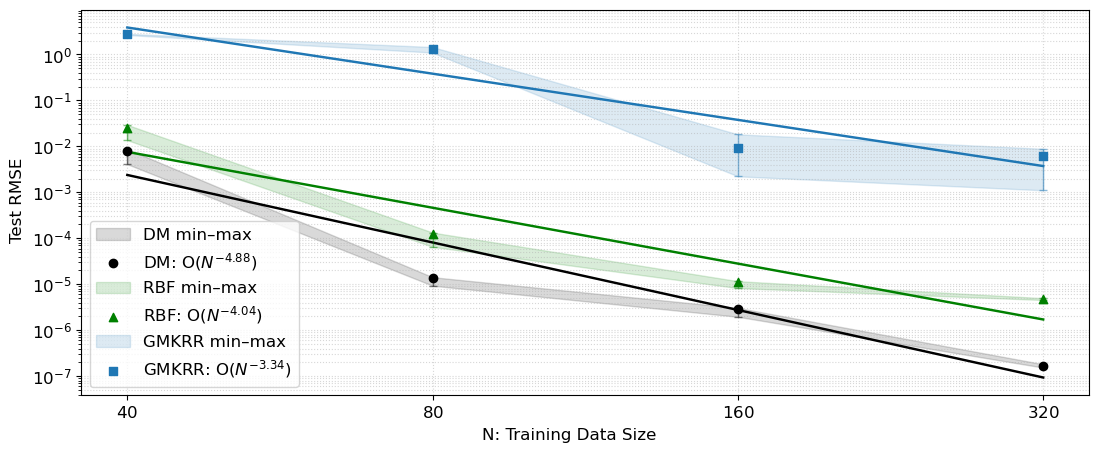

In [6]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter, FixedLocator

def log2_formatter(x, pos):
    return f"$2^{{{int(np.log2(x))}}}$"

num_points_array = [40, 80, 160, 320]

modes = ["diffusion", "rbf"]
mode_to_label = {"diffusion": "DM", "rbf": "RBF"}
mode_to_color = {"diffusion": "black", "rbf": "green"}
mode_to_marker = {"diffusion": "o", "rbf": "^"}

# GMKRR styling
gmkrr_label  = "GMKRR"
gmkrr_color  = "tab:blue"
gmkrr_marker = "s"

map_type_list = ["skip-connection"]  # rows

plt.rcParams.update({"font.size": 12})

fig, axs = plt.subplots(1, 1, figsize=(13, 5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.15, wspace=0.025)

if not isinstance(axs, (list, np.ndarray)):
    axs = [axs]

for row_idx, map_type in enumerate(map_type_list):
    ax = axs[row_idx]

    # ----- DM / RBF (unchanged) -----
    for mode in modes:
        xs, y_mean, y_min, y_max = [], [], [], []
        for num_points in num_points_array:
            try:
                results = pl.read_parquet(
                    f"./numerical_results/ks_beat_{mode}_{num_points}_{map_type}_no_proj_fully_scaled.parquet"
                )
                raw = results["rmse"][0]  # list/array in first row
                rmse = np.asarray(raw, dtype=float).ravel()
                rmse = rmse[np.isfinite(rmse)]
                rmse = rmse[rmse > 0]
                if rmse.size == 0:
                    continue
                xs.append(num_points)
                y_mean.append(float(np.mean(rmse)))
                y_min.append(float(np.min(rmse)))
                y_max.append(float(np.max(rmse)))
            except Exception:
                continue

        if len(xs) > 0:
            xs = np.asarray(xs, dtype=float)
            y_mean = np.asarray(y_mean, dtype=float)
            y_min  = np.asarray(y_min,  dtype=float)
            y_max  = np.asarray(y_max,  dtype=float)
            order = np.argsort(xs)
            xs, y_mean, y_min, y_max = xs[order], y_mean[order], y_min[order], y_max[order]

            ax.fill_between(xs, y_min, y_max, alpha=0.15, color=mode_to_color[mode],
                            label=f"{mode_to_label[mode]} min–max")
            sc = ax.scatter(xs, y_mean, color=mode_to_color[mode],
                            marker=mode_to_marker[mode], zorder=3)

            yerr_lower = y_mean - y_min
            yerr_upper = y_max - y_mean
            ax.errorbar(xs, y_mean, yerr=[yerr_lower, yerr_upper],
                        fmt="none", ecolor=mode_to_color[mode], elinewidth=1,
                        capsize=3, alpha=0.5, zorder=2)

            if y_mean.size >= 2:
                m, c = np.polyfit(np.log(xs), np.log(y_mean), 1)
                ax.plot(xs, np.exp(m * np.log(xs) + c), color=mode_to_color[mode], linewidth=1.75)
                sc.set_label(f"{mode_to_label[mode]}: O$\\left(N^{{{m:.2f}}}\\right)$")
            else:
                sc.set_label(mode_to_label[mode])

    # ----- GMKRR overlay (new) -----
    xs_g, y_mean_g, y_min_g, y_max_g = [], [], [], []
    for num_points in num_points_array:
        try:
            # gmkrr = pl.read_parquet(f"./numerical_results/ks_beating_gmkrr_{num_points}_scaled.parquet")
            # print(gmkrr["rmse_t"][0].shape)
            # raw_g = gmkrr["rmse_t"]  # list/array in first row (max over time, per trial)

            gmkrr = pl.read_parquet(f"./numerical_results/ks_beating_gmkrr_{num_points}_fully_scaled.parquet")
            print(gmkrr["rmse"][0].shape)
            raw_g = gmkrr["rmse"][0]  # list/array in first row (max over time, per trial)
            rmse_g = np.asarray(raw_g, dtype=float).ravel()
            rmse_g = rmse_g[np.isfinite(rmse_g)]
            rmse_g = rmse_g[rmse_g > 0]
            if rmse_g.size == 0:
                continue
            xs_g.append(num_points)
            y_mean_g.append(float(np.mean(rmse_g)))
            y_min_g.append(float(np.min(rmse_g)))
            y_max_g.append(float(np.max(rmse_g)))
        except Exception:
            continue

    if len(xs_g) > 0:
        xs_g = np.asarray(xs_g, dtype=float)
        y_mean_g = np.asarray(y_mean_g, dtype=float)
        y_min_g  = np.asarray(y_min_g,  dtype=float)
        y_max_g  = np.asarray(y_max_g,  dtype=float)
        order_g = np.argsort(xs_g)
        xs_g, y_mean_g, y_min_g, y_max_g = xs_g[order_g], y_mean_g[order_g], y_min_g[order_g], y_max_g[order_g]

        ax.fill_between(xs_g, y_min_g, y_max_g, alpha=0.15, color=gmkrr_color, label=f"{gmkrr_label} min–max")
        scg = ax.scatter(xs_g, y_mean_g, color=gmkrr_color, marker=gmkrr_marker, zorder=3)

        yerr_lower_g = y_mean_g - y_min_g
        yerr_upper_g = y_max_g - y_mean_g
        ax.errorbar(xs_g, y_mean_g, yerr=[yerr_lower_g, yerr_upper_g],
                    fmt="none", ecolor=gmkrr_color, elinewidth=1, capsize=3, alpha=0.5, zorder=2)

        if y_mean_g.size >= 2:
            mg, cg = np.polyfit(np.log(xs_g), np.log(y_mean_g), 1)
            ax.plot(xs_g, np.exp(mg * np.log(xs_g) + cg), color=gmkrr_color, linewidth=1.75)
            scg.set_label(f"{gmkrr_label}: O$\\left(N^{{{mg:.2f}}}\\right)$")
        else:
            scg.set_label(gmkrr_label)

    ax.legend()

# Shared axes formatting
for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.set_xticks(num_points_array)
    ax.set_xticklabels(["$40$", "$80$", "$160$", "$320$"])
    ax.grid(True, which="both", linestyle=":", alpha=0.5)

# Shared labels & title
fig.text(0.5, 0.02, "N: Training Data Size", ha="center")
fig.text(0.07, 0.5, "Test RMSE", va="center", rotation="vertical")
# plt.suptitle("KS Beating Dynamics: RMSE vs Training Data Size (mean ± min–max)", y=0.98)
plt.savefig("./pics/KS_beating_test_rmse.pdf", bbox_inches="tight", dpi=300)
plt.show()


Mode = diffusion, num points = 40
False
Mode = diffusion, num points = 80
False
Mode = diffusion, num points = 160
False
Mode = diffusion, num points = 320
False
Mode = rbf, num points = 40
False
Mode = rbf, num points = 80
False
Mode = rbf, num points = 160
False
Mode = rbf, num points = 320
False
Mode = shape: (1, 4)
┌────────────┬───────────┬─────────────────────────────────┬─────────────────────────────────┐
│ epsilon    ┆ lambda    ┆ rmse                            ┆ path                            │
│ ---        ┆ ---       ┆ ---                             ┆ ---                             │
│ f64        ┆ f64       ┆ list[f64]                       ┆ list[list[list[f64]]]           │
╞════════════╪═══════════╪═════════════════════════════════╪═════════════════════════════════╡
│ 136.120511 ┆ 1.6102e-8 ┆ [2.708114, 2.726847, … 2.75245… ┆ [[[1.044352, 1.258877, … 0.800… │
└────────────┴───────────┴─────────────────────────────────┴─────────────────────────────────┘, num points = 

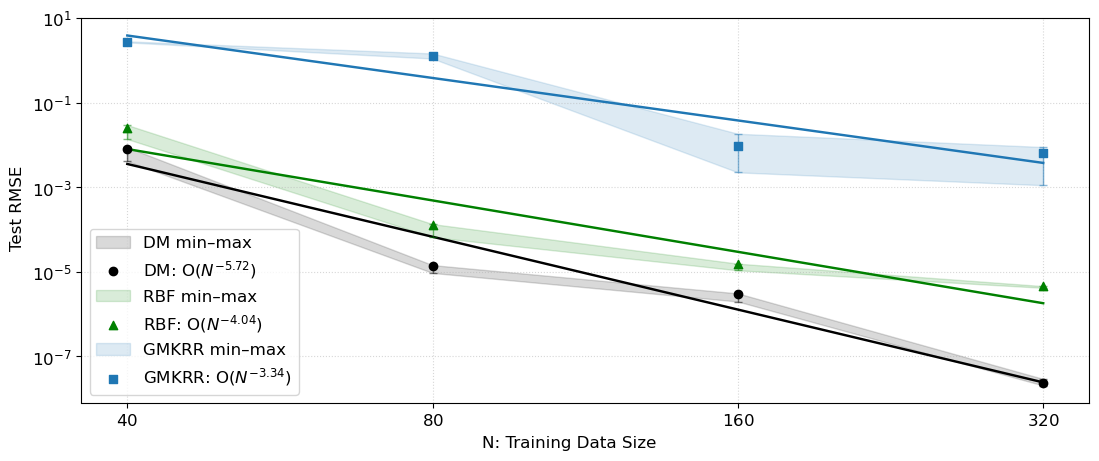

In [38]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter, FixedLocator

def log2_formatter(x, pos):
    return f"$2^{{{int(np.log2(x))}}}$"

num_points_array = [40, 80, 160, 320]

modes = ["diffusion", "rbf"]
mode_to_label = {"diffusion": "DM", "rbf": "RBF"}
mode_to_color = {"diffusion": "black", "rbf": "green"}
mode_to_marker = {"diffusion": "o", "rbf": "^"}

# GMKRR styling
gmkrr_label  = "GMKRR"
gmkrr_color  = "tab:blue"
gmkrr_marker = "s"

map_type_list = ["skip-connection"]  # rows

plt.rcParams.update({"font.size": 12})

fig, axs = plt.subplots(1, 1, figsize=(13, 5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.15, wspace=0.025)

if not isinstance(axs, (list, np.ndarray)):
    axs = [axs]

for row_idx, map_type in enumerate(map_type_list):
    ax = axs[row_idx]

    # ----- DM / RBF (unchanged) -----
    for mode in modes:
        xs, y_mean, y_min, y_max = [], [], [], []
        for num_points in num_points_array:
            print(f"Mode = {mode}, num points = {num_points}")
            try:
                results = pl.read_parquet(
                    f"./numerical_results/ks_beat_{mode}_{num_points}_{map_type}_no_proj_fully_scaled.parquet"
                )
                raw = results["rmse"][0]  # list/array in first row
                rmse = np.asarray(raw, dtype=float).ravel()
                rmse = rmse[np.isfinite(rmse)]
                print(np.isnan(rmse).any())
                rmse = rmse[rmse > 0]
                if rmse.size == 0:
                    continue
                xs.append(num_points)
                y_mean.append(float(np.mean(rmse)))
                y_min.append(float(np.min(rmse)))
                y_max.append(float(np.max(rmse)))
            except Exception:
                continue

        if len(xs) > 0:
            xs = np.asarray(xs, dtype=float)
            y_mean = np.asarray(y_mean, dtype=float)
            y_min  = np.asarray(y_min,  dtype=float)
            y_max  = np.asarray(y_max,  dtype=float)
            order = np.argsort(xs)
            xs, y_mean, y_min, y_max = xs[order], y_mean[order], y_min[order], y_max[order]

            ax.fill_between(xs, y_min, y_max, alpha=0.15, color=mode_to_color[mode],
                            label=f"{mode_to_label[mode]} min–max")
            sc = ax.scatter(xs, y_mean, color=mode_to_color[mode],
                            marker=mode_to_marker[mode], zorder=3)

            yerr_lower = y_mean - y_min
            yerr_upper = y_max - y_mean
            ax.errorbar(xs, y_mean, yerr=[yerr_lower, yerr_upper],
                        fmt="none", ecolor=mode_to_color[mode], elinewidth=1,
                        capsize=3, alpha=0.5, zorder=2)

            if y_mean.size >= 2:
                m, c = np.polyfit(np.log(xs), np.log(y_mean), 1)
                ax.plot(xs, np.exp(m * np.log(xs) + c), color=mode_to_color[mode], linewidth=1.75)
                sc.set_label(f"{mode_to_label[mode]}: O$\\left(N^{{{m:.2f}}}\\right)$")
            else:
                sc.set_label(mode_to_label[mode])

    # ----- GMKRR overlay (new) -----
    xs_g, y_mean_g, y_min_g, y_max_g = [], [], [], []
    for num_points in num_points_array:
        try:
            # gmkrr = pl.read_parquet(f"./numerical_results/ks_beating_gmkrr_{num_points}_scaled.parquet")
            # print(gmkrr["rmse_t"][0].shape)
            # raw_g = gmkrr["rmse_t"]  # list/array in first row (max over time, per trial)

            gmkrr = pl.read_parquet(f"./numerical_results/ks_beating_gmkrr_{num_points}_fully_scaled.parquet")
            print(f"Mode = {gmkrr}, num points = {num_points}")
            print(np.isnan(gmkrr["rmse"][0].to_numpy()).any())
            raw_g = gmkrr["rmse"][0]  # list/array in first row (max over time, per trial)
            rmse_g = np.asarray(raw_g, dtype=float).ravel()
            rmse_g = rmse_g[np.isfinite(rmse_g)]
            rmse_g = rmse_g[rmse_g > 0]
            if rmse_g.size == 0:
                continue
            xs_g.append(num_points)
            y_mean_g.append(float(np.mean(rmse_g)))
            y_min_g.append(float(np.min(rmse_g)))
            y_max_g.append(float(np.max(rmse_g)))
        except Exception:
            continue

    if len(xs_g) > 0:
        xs_g = np.asarray(xs_g, dtype=float)
        y_mean_g = np.asarray(y_mean_g, dtype=float)
        y_min_g  = np.asarray(y_min_g,  dtype=float)
        y_max_g  = np.asarray(y_max_g,  dtype=float)
        order_g = np.argsort(xs_g)
        xs_g, y_mean_g, y_min_g, y_max_g = xs_g[order_g], y_mean_g[order_g], y_min_g[order_g], y_max_g[order_g]

        ax.fill_between(xs_g, y_min_g, y_max_g, alpha=0.15, color=gmkrr_color, label=f"{gmkrr_label} min–max")
        scg = ax.scatter(xs_g, y_mean_g, color=gmkrr_color, marker=gmkrr_marker, zorder=3)

        yerr_lower_g = y_mean_g - y_min_g
        yerr_upper_g = y_max_g - y_mean_g
        ax.errorbar(xs_g, y_mean_g, yerr=[yerr_lower_g, yerr_upper_g],
                    fmt="none", ecolor=gmkrr_color, elinewidth=1, capsize=3, alpha=0.5, zorder=2)

        if y_mean_g.size >= 2:
            mg, cg = np.polyfit(np.log(xs_g), np.log(y_mean_g), 1)
            ax.plot(xs_g, np.exp(mg * np.log(xs_g) + cg), color=gmkrr_color, linewidth=1.75)
            scg.set_label(f"{gmkrr_label}: O$\\left(N^{{{mg:.2f}}}\\right)$")
        else:
            scg.set_label(gmkrr_label)

    ax.legend(fontsize=12)

# Shared axes formatting
for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10) * 0.1))

    ax.set_xticks(num_points_array)
    ax.set_xticklabels(["$40$", "$80$", "$160$", "$320$"])
    ax.grid(True, which="both", linestyle=":", alpha=0.5)

# Shared labels & title
fig.text(0.5, 0.02, "N: Training Data Size", ha="center", fontsize=12)
fig.text(0.07, 0.5, "Test RMSE", va="center", rotation="vertical", fontsize=12)
# plt.suptitle("KS Beating Dynamics: RMSE vs Training Data Size (mean ± min–max)", y=0.98)
plt.savefig("./journal_pics/KS_beating_test_rmse.png", bbox_inches="tight", dpi=600, transparent=True)
plt.show()


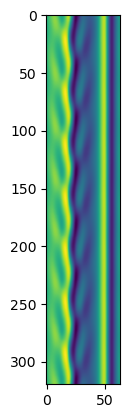

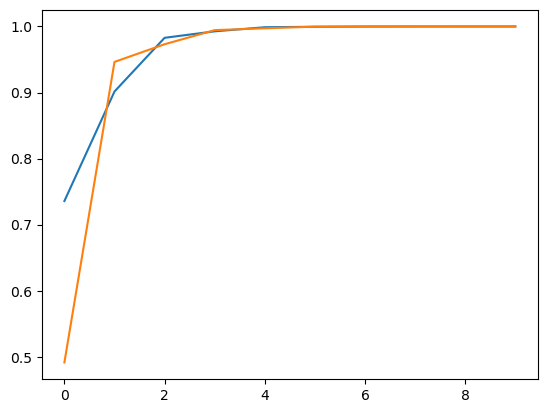

In [ ]:
import pickle
import general_utils
import cupy as cp
import numpy as np
from scipy.fft import fft, fftfreq
import polars as pl
from matplotlib import pyplot as plt

validation_horizon = 30
validation_repeats = 10
test_trials = 32
steps = 500
num_points = 320

def load_data():
    NT = 5_000_000
    DT = 1e-4
    TS = 100
    data = pickle.load(open(f"./ks_utils/ksdata_beating_NT_{NT}_dt_{DT}_ts_{TS}.pkl", "rb"))
    dt = data["dt"]; xx = data["x"]; tt = data["t"]
    uu = data["udata"].astype(np.float64)

    Nx, Nt = len(xx), len(tt)
    assert uu.shape == (Nt, Nx)

    data_train = uu[:num_points]

    mean = np.mean(data_train, axis=0)
    std  = np.std(data_train, axis=0)
    data_train_n = (data_train - mean) / std

    return dt, data_train, data_train_n
dt, data_train, data_train_n, = load_data()

u, s, vh = np.linalg.svd(data_train, full_matrices=False)
un, sn, vhn = np.linalg.svd(data_train_n, full_matrices=False)
fig, ax = plt.subplots()
ax.imshow(data_train)

s_sum = np.cumsum(s) 
s_norm = s_sum / s_sum[-1]

sn_sum = np.cumsum(sn) 
sn_norm = sn_sum / sn_sum[-1]

fig, ax = plt.subplots()
ax.plot(s_norm[:10])
ax.plot(sn_norm[:10])

Manifold info:
    No. of data points: 160
    No. of ambient dim: 64
----Fitting...
Manifold info:
    No. of data points: 160
    No. of ambient dim: 64
  Precomputing
    Using intrinsic dimension: 1
  Done
------Form K...
    t = 2.102e-03
------Linear solve...
    t = 7.861e-04
----Done
====Solving [0.0, 4.99]


100%|██████████| 499/499 [00:00<00:00, 838.24it/s]


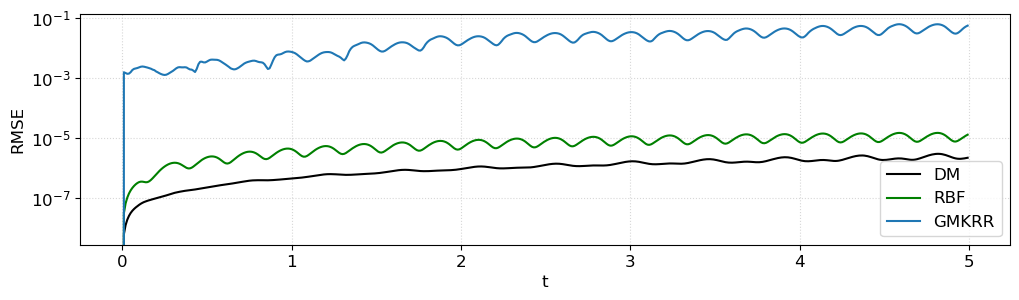

In [17]:
import pickle
import general_utils
import cupy as cp
import numpy as np
from scipy.fft import fft, fftfreq
import polars as pl
from matplotlib import pyplot as plt

# ---------- GMKRR imports ----------
import sys
abs_path_root = "/home/jzs6565/dm_code/dm_final/gindy/src/"
sys.path.append(abs_path_root)
from manifold import Manifold
from kernelreg import M2KRR
from gindy import DynRegMan
from utils import make_se
# -----------------------------------

validation_horizon = 30
validation_repeats = 10
test_trials = 32

def ffft(x, y):
    _N = len(x); _T = x[1]-x[0]
    _y = fft(y)[0:_N//2]; _x = fftfreq(_N, _T)[:_N//2]
    _s = 2/_N * np.abs(_y)
    return _x, _s

def load_data():
    NT = 5_000_000
    DT = 1e-4
    TS = 100
    data = pickle.load(open(f"./ks_utils/ksdata_beating_NT_{NT}_dt_{DT}_ts_{TS}.pkl", "rb"))
    dt = data["dt"]; xx = data["x"]; tt = data["t"]
    uu = data["udata"].astype(np.float64)

    Nx, Nt = len(xx), len(tt)
    assert uu.shape == (Nt, Nx)

    data_train = uu[:num_points]

    mean = np.mean(data_train, axis=0)
    std  = np.std(data_train, axis=0)
    data_train_n = (data_train - mean) / std

    data_train_x = data_train_n[:-1]
    data_train_y = data_train_n[1:]

    data_val = uu[:num_points]
    data_val = (data_val - mean) / std

    data_test = []
    start0 = num_points + validation_repeats * validation_horizon
    for _ in range(test_trials):
        s = start0 + _ * steps
        e = s + steps
        data_test.append([(uu[s:e] - mean) / std])

    return dt, data_train_x, data_train_y, data_val, data_test, mean, std

num_points = 160
steps = 500
mode_lst = ['diffusion', 'rbf']
mode_labels = ['DM', 'RBF']
map_type_lst = ['skip-connection']
colors = ['k', 'g']

dt, data_train_x, data_train_y, data_val, data_test, mean, std = load_data()
t = np.linspace(0, (steps-1)*dt, steps)

fig, ax = plt.subplots(nrows=1, figsize=(12, 3))

# -------- DM / RBF curves (as before) --------
for _i, mode in enumerate(mode_lst):
    for _j, map_type in enumerate(map_type_lst):
        opts = {'map_type': map_type, 'norm': False}
        opts['inp'] = data_train_x
        opts['out'] = data_train_y

        cv_results = pl.read_parquet(
            f"./numerical_results/ks_beat_cv_{mode}_{num_points}_{map_type}_no_proj_fully_scaled.parquet"
        )
        cv_rmse = cv_results["rmse"]
        index = cv_rmse.arg_min()
        epsilon, lambda_reg = (cv_results["epsilon"][index], cv_results["lambda"][index])

        model = general_utils.modeler(**opts)
        model.fit_model(epsilon, lambda_reg, mode)

        truePath = cp.array(data_test[20]).squeeze()  # [steps, Nx] normalized
        test_point = cp.asarray(truePath[0])
        pred_path = [cp.array(test_point).get()]
        for i in range(steps-1):
            test_point = model.forecast(test_point)
            pred_path.append(test_point.get().flatten())
        pred_path = cp.array(pred_path)

        # Back to physical units for RMSE
        truePath = truePath.get()
        pred_path = pred_path.get()
        truePath_ph = std[None, :] * truePath + mean[None, :]
        pred_path_ph = std[None, :] * pred_path + mean[None, :]

        rmse = np.sqrt(np.mean((pred_path_ph - truePath_ph)**2, axis=-1))
        ax.semilogy(t, rmse, color=colors[_i], label=f"{mode_labels[_i]}")
        ax.grid(True, which='both', linestyle=':', alpha=0.5)
        ax.set_xlabel('t', fontsize=12)
        ax.set_ylabel('RMSE', fontsize=12)


data_train = np.vstack([data_train_x, data_train_y[-1:]]) * std[None, :] + mean[None, :]

# Build manifold on training trajectory and fit GMKRR
man = Manifold(data_train, d=2)
order_fd = '1'
manopt = {'d': 1, 'g': 4, 'T': 0}
regloc = {
    'man'   : Manifold,
    'manopt': manopt,
    'ker'   : make_se(440.163),
    'nug'   : 1e-6,
    'ifvec' : True
}
dloc = DynRegMan(M2KRR, regloc, fd=order_fd, dt=dt)
dloc.fit([data_train])

# Use the SAME test trajectory (#20), convert to physical units
truePath_n = np.array(data_test[20]).squeeze()           # [steps, Nx] normalized
truePath_ph = std[None, :] * truePath_n + mean[None, :]  # physical
a0 = truePath_ph[0]
sol = dloc.solve(a0, t)                                  # [steps, Nx] physical

rmse_gmkrr = np.sqrt(np.mean((sol - truePath_ph)**2, axis=-1))
ax.semilogy(t, rmse_gmkrr, color='tab:blue', label='GMKRR')

# ------------- finalize -------------
ax.legend()
fig.savefig(f"./journal_pics/ks_beating_prediction_N_{num_points}.png",
            bbox_inches="tight", dpi=600, transparent=True)


100%|██████████| 499/499 [00:00<00:00, 1377.65it/s]


mode = diffusion, RMSE at final time = 5.916e-07, mean RMSE = 2.384e-07


100%|██████████| 499/499 [00:00<00:00, 2560.08it/s]


mode = rbf, RMSE at final time = 3.508e-06, mean RMSE = 1.497e-06
Manifold info:
    No. of data points: 160
    No. of ambient dim: 64
----Fitting...
Manifold info:
    No. of data points: 160
    No. of ambient dim: 64
  Precomputing
    Using intrinsic dimension: 1
  Done
------Form K...
    t = 1.827e-03
------Linear solve...
    t = 6.683e-04
----Done
====Solving [0.0, 4.99]


100%|██████████| 499/499 [00:00<00:00, 828.59it/s]
/tmp/ipykernel_4117502/898165561.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 0.98])


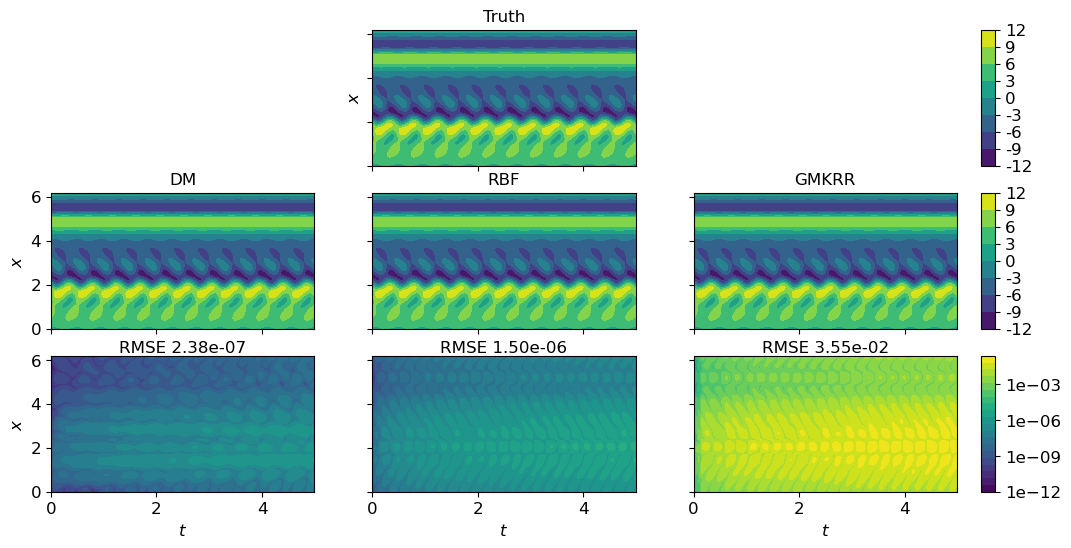

In [18]:
import sys
import numpy as np
import polars as pl
import cupy as cp
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter, LogLocator, LogFormatter
from matplotlib.colors import LogNorm

# --- project imports (assumed available in your env) ---
import general_utils
abs_path_root = "/home/jzs6565/dm_code/dm_final/gindy/src/"
sys.path.append(abs_path_root)
from manifold import Manifold

fontsize = 12

num_points = 160
steps      = 500
dt_plot    = 0.01
dt         = dt_plot
DOMAIN_SIZE = 2 * np.pi
N_DOF = 64

x = np.linspace(0.0, DOMAIN_SIZE, N_DOF, endpoint=False)  # y-axis coords
t = np.linspace(0, dt_plot * (steps - 1), steps)          # x-axis coords
X, T = np.meshgrid(x, t)

# Load data (assumed provided)
_, data_train_x, data_train_y, data_val, data_test, mean, std = load_data()

mode_lst = ['diffusion', 'rbf']

# =================== Helpers ===================
def _clip_positive(a, eps=1e-12):
    """Ensure strictly positive values for log-normalization."""
    return np.clip(a, eps, None)

def forecast_path(mode, map_type):
    opts = {'map_type': map_type, 'norm': False, 'inp': data_train_x, 'out': data_train_y}
    cv   = pl.read_parquet(
        f"./numerical_results/ks_beat_cv_{mode}_{num_points}_{map_type}_no_proj_fully_scaled.parquet"
    )
    i   = cv["rmse"].arg_min()
    eps = float(cv["epsilon"][i])
    lam = float(cv["lambda"][i])

    model = general_utils.modeler(**opts)
    model.fit_model(eps, lam, mode)

    # test trajectory (normalized)
    true_cp = cp.array(data_test[0]).squeeze()   # (steps, Nx)
    x0      = cp.asarray(true_cp[0])

    preds = [cp.array(x0).get()]
    x = x0
    for _ in tqdm(range(steps - 1)):
        x = model.forecast(x)
        preds.append(x.get().flatten())
    pred_np = np.asarray(preds)

    # back to physical scale
    true_np = true_cp.get()
    true_np = std[None, :] * true_np + mean
    pred_np = std[None, :] * pred_np + mean
    return true_np, pred_np

def prettify_cbar(cb, nbins=5 , ticks=None):
    cb.locator = MaxNLocator(nbins=nbins, prune=None, steps=[1, 2, 2.5, 5, 10])
    fmt = ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((-2, 3))
    cb.formatter = fmt
    cb.update_ticks()
    ticks = [-12, -9, -6, -3, 0, 3, 6, 9, 12]
    if ticks is not None:
        cb.set_ticks(ticks)
        cb.set_ticklabels([f"{t:g}" for t in ticks])

def prettify_cbar_log(cb, base=10):
    cb.locator   = LogLocator(base=base)
    cb.formatter = LogFormatter(base=base)
    cb.update_ticks()

def add_row_colorbar(fig, row_axes, mappable, left=0.90, width=0.02):
    bottoms = [ax.get_position().y0 for ax in row_axes]
    tops    = [ax.get_position().y1 for ax in row_axes]
    bottom  = min(bottoms)
    top     = max(tops)
    height  = top - bottom
    cax = fig.add_axes([left, bottom, width, height])
    return fig.colorbar(mappable, cax=cax)

# =================== Kernel methods (DM/RBF) ===================
results = {}
for mode in mode_lst:
    true_m, pred_s = forecast_path(mode, 'skip-connection')
    err_s  = np.abs(pred_s - true_m)
    rmse_s = float(np.sqrt(np.mean((pred_s - true_m) ** 2)))
    results[mode] = {
        'true': true_m,
        'pred_skip': pred_s,
        'err_skip':  err_s,
        'rmse_skip': rmse_s,
    }
    rmse_at_final_t = np.sqrt(np.mean(err_s**2, axis=-1))[-1]
    print(f"mode = {mode}, RMSE at final time = {rmse_at_final_t:.3e}, mean RMSE = {rmse_s:.3e}")

# =================== GMKRR method ===================
data_train = np.vstack([data_train_x, data_train_y[-1:]]) * std[None, :] + mean[None, :]
man = Manifold(data_train, d=2)
order_fd = '1'
manopt = {'d': 1, 'g': 4, 'T': 0}
regloc = {
    'man'   : Manifold,
    'manopt': manopt,
    'ker'   : make_se(440.163),
    'nug'   : 1e-6,
    'ifvec' : True
}

dloc = DynRegMan(M2KRR, regloc, fd=order_fd, dt=dt)
dloc.fit([data_train])

truePath_n  = np.array(data_test[0]).squeeze()
truePath_ph = std[None, :] * truePath_n + mean[None, :]
a0 = truePath_ph[0]
gmkrr_sol = dloc.solve(a0, t)

# =================== Plotting ===================
fig = plt.figure(figsize=(12, 6))
gs  = fig.add_gridspec(nrows=3, ncols=3, right=0.88, hspace=0.20, wspace=0.22)

# hub axis (others will share x/y with this one)
ax_truth       = fig.add_subplot(gs[0, 1])

ax_dm_skip     = fig.add_subplot(gs[1, 0], sharex=ax_truth, sharey=ax_truth)
ax_rbf_skip    = fig.add_subplot(gs[1, 1], sharex=ax_truth, sharey=ax_truth)
ax_gmkrr       = fig.add_subplot(gs[1, 2], sharex=ax_truth, sharey=ax_truth)

ax_dm_err2     = fig.add_subplot(gs[2, 0], sharex=ax_truth, sharey=ax_truth)
ax_rbf_err2    = fig.add_subplot(gs[2, 1], sharex=ax_truth, sharey=ax_truth)
ax_gmkrr_err2  = fig.add_subplot(gs[2, 2], sharex=ax_truth, sharey=ax_truth)

# Truth
im_truth = ax_truth.contourf(T, X, results['diffusion']['true'])
truth_levels = im_truth.levels  # reuse for predictions for fair comparison

# Predictions (linear color scale, matching truth levels)
im_dm_skip   = ax_dm_skip.contourf( T, X, results['diffusion']['pred_skip'], levels=truth_levels)
im_rbf_skip  = ax_rbf_skip.contourf(T, X, results['rbf']['pred_skip'],       levels=truth_levels)
im_gmkrr     = ax_gmkrr.contourf(   T, X, gmkrr_sol,                         levels=truth_levels)

# -------- Errors (LOG color scale) --------
dm_err = np.abs(results['diffusion']['pred_skip'] - results['diffusion']['true'])
rbf_err = np.abs(results['rbf']['pred_skip'] - results['diffusion']['true'])
gmkrr_err = np.abs(gmkrr_sol - results['diffusion']['true'])

# Clip errors to avoid zeros (log scale requires > 0)
err_dm  = _clip_positive(dm_err)
err_rbf = _clip_positive(rbf_err)
err_gmk = _clip_positive(gmkrr_err)

# Common vmin/vmax across all three error plots
vmax_err = float(max(err_dm.max(), err_rbf.max(), err_gmk.max()))
vmin_err = float(min(err_dm[err_dm > 0].min(),
                     err_rbf[err_rbf > 0].min(),
                     err_gmk[err_gmk > 0].min()))

# Log-spaced contour levels + LogNorm
levels_err_log = np.logspace(np.log10(vmin_err), np.log10(vmax_err), 21)
lognorm = LogNorm(vmin=vmin_err, vmax=vmax_err)

im_dm_err2     = ax_dm_err2.contourf( T, X, err_dm,  levels=levels_err_log, norm=lognorm)
im_rbf_err2    = ax_rbf_err2.contourf(T, X, err_rbf, levels=levels_err_log, norm=lognorm)
im_gmkrr_err2  = ax_gmkrr_err2.contourf(T, X, err_gmk, levels=levels_err_log, norm=lognorm)

dm_rmse = float(np.sqrt(np.mean((dm_err) ** 2)))
rbf_rmse = float(np.sqrt(np.mean((rbf_err) ** 2)))
gmkrr_rmse = float(np.sqrt(np.mean((gmkrr_err) ** 2)))

# Titles & labels
ax_truth.set_title('Truth', fontsize=fontsize)
ax_dm_skip.set_title('DM', fontsize=fontsize)
ax_rbf_skip.set_title('RBF', fontsize=fontsize)
ax_gmkrr.set_title('GMKRR', fontsize=fontsize)

ax_truth.set_ylabel('$x$', fontsize=fontsize)
ax_dm_skip.set_ylabel('$x$', fontsize=fontsize)
ax_truth.set_xlabel('$t$', fontsize=fontsize)
ax_dm_err2.set_ylabel('$x$', fontsize=fontsize)

ax_dm_err2.set_title(f"RMSE {dm_rmse:.2e}", fontsize=fontsize, pad=2)
ax_rbf_err2.set_title(f"RMSE {rbf_rmse:.2e}",     fontsize=fontsize, pad=2)
ax_gmkrr_err2.set_title(f"RMSE {gmkrr_rmse:.2e}",                    fontsize=fontsize, pad=2)

# Domain on the hub axis
ax_truth.set_xlim(t[0], t[-1])
ax_truth.set_ylim(x[0], x[-1])
ax_truth.set_xticks([0.0, 2.0, 4.0])

axes_shared = [ax_truth, ax_dm_skip, ax_rbf_skip, ax_gmkrr, ax_dm_err2, ax_rbf_err2, ax_gmkrr_err2]
for ax in axes_shared:
    ax.set_xlim(ax_truth.get_xlim())
    ax.set_ylim(ax_truth.get_ylim())
    ax.set_autoscale_on(False)
    ax.label_outer()

ax_dm_err2.set_xlabel("$t$", fontsize=fontsize)
ax_rbf_err2.set_xlabel("$t$", fontsize=fontsize)
ax_gmkrr_err2.set_xlabel("$t$", fontsize=fontsize)

plt.tight_layout(rect=[0, 0, 0.88, 0.98])

row0_axes = [ax_truth]
row2_axes = [ax_dm_skip, ax_rbf_skip, ax_gmkrr]
row3_axes = [ax_dm_err2, ax_rbf_err2, ax_gmkrr_err2]

cb0 = add_row_colorbar(fig, row0_axes, im_truth,   left=0.90, width=0.012)
cb2 = add_row_colorbar(fig, row2_axes, im_dm_skip, left=0.90, width=0.012)
cb3 = add_row_colorbar(fig, row3_axes, im_dm_err2, left=0.90, width=0.012)

# Format colorbars: linear for truth/preds; log for errors
ticks = [-12, -9, -6, -3, 0, 3, 6, 9, 12]
prettify_cbar(cb0, nbins=5, ticks=ticks)
prettify_cbar(cb2, nbins=5, ticks=ticks)
prettify_cbar_log(cb3, base=10)
ax_truth.set_ylabel('$x$', fontsize=fontsize)

fig.savefig(f"journal_pics/ks_beating_prediction_results_N_{num_points}.png", dpi=600, bbox_inches='tight', transparent=True)

# K-S Traveling

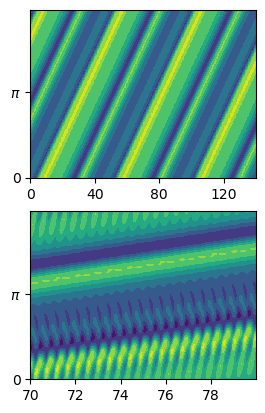

In [ ]:
NT = 5000000
SKP = 500000
DT = 0.001
TS = 10
data = pickle.load(open(f"./ks_utils/ksdata_traveling_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
dt = data["dt"]; xx = data["x"]; tt = data["t"]
uut = data["udata"].astype(np.float64)

T = 14000
Noffset = 6000
fig = plt.figure()
ax = fig.add_subplot(221)
ax.contourf(tt[:T], xx, uut[Noffset:Noffset+T].T)
ax.set_yticks([0, xx[len(xx)//2]], ['0', r'$\pi$'])
ax.set_xticks([0, 40, 80, 120])

ax = fig.add_subplot(223)
so = 6000
ax.contourf(tt[7000:8000], xx, uut[Noffset+so:Noffset+so+1000].T)
ax.set_yticks([0, xx[len(xx)//2]], ['0', r'$\pi$'])
# ax.set_xticks([0, 40, 80, 120])

(3000, 64)
Manifold info:
    No. of data points: 2999
    No. of ambient dim: 64
    Estimated intrinsic dim: 3/2.8911216812931455
2**res.x * dmx = 1395.8894948395805
    Reference bandwidth 12.239440431886875; ref L2 dist 6660.21458723591; ref scalar 0.2095862643096753
eps_c = 54.52693339217112
eps_c = 54.52693339217112
2519
(3000, 64)
Manifold info:
    No. of data points: 2999
    No. of ambient dim: 64
    Estimated intrinsic dim: 3/2.8911216812931455
2**res.x * dmx = 1395.8894948395805
    Reference bandwidth 12.239440431886875; ref L2 dist 6660.21458723591; ref scalar 0.2095862643096753
eps_c = 54.52693339217112
eps_c = 54.52693339217112
2674


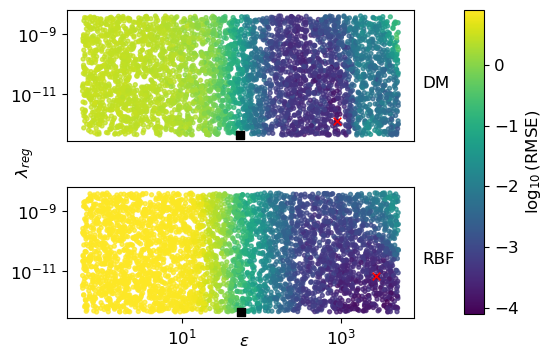

In [7]:
import os
import numpy as np
import polars as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import pickle
from gindy.src.manifold import Manifold


devices = 4
modes = ["diffusion", "rbf"]
mode_labels = {"diffusion": "DM", "rbf": "RBF"}
num_points_lst = [6000]
map_type = "skip-connection"
test_trials = 1
steps = 14000 

plt.rcParams.update({"font.size": 12})

def load_data():

    NT = 5000000
    SKP = 500000
    DT = 0.001
    TS = 10
    data = pickle.load(open(f"./ks_utils/ksdata_traveling_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
    dt = data["dt"]
    nu = data["nu"]
    xx = data["x"]
    tt = data["t"]
    uu = data["udata"].astype(np.float64)
    
    Nx, Nt = len(xx), len(tt)
    assert uu.shape == (Nt, Nx)

    data_train = uu[:num_points:2]
    print(data_train.shape)
    dt = dt * 2

    data_train_x = data_train[:-1]
    data_train_y = data_train[1:]

    return dt, data_train_x, data_train_y

global_min = np.inf
global_max = -np.inf
existing = {}

for mode in modes:
    for num_points in num_points_lst:
        fname = f"./numerical_results/ks_traveling_cv_{mode}_{num_points}_{map_type}_dt_0.02_seed_1442.parquet"
        if not os.path.exists(fname):
            continue
        df = pl.read_parquet(fname)
        existing[(mode, num_points)] = df

        rmse = df["rmse"].to_numpy()
        mask = np.isfinite(rmse) & (rmse > 0)
        if not np.any(mask):
            continue
        log_rmse = np.log10(rmse[mask])
        global_min = min(global_min, np.nanmin(log_rmse))
        global_max = max(global_max, np.nanmax(log_rmse))

if not np.isfinite(global_min) or not np.isfinite(global_max):
    raise RuntimeError("No valid RMSE values > 0 found across the provided parquet files.")

nrows = len(modes)
ncols = len(num_points_lst)

fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(5, 4),
    sharex=False, sharey=False
)

fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)

norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)
cmap = "viridis"

for i_mode, mode in enumerate(modes):
    row = i_mode
    for j, num_points in enumerate(num_points_lst):
        
        dt, data_train_x, data_train_y = load_data()
        man = Manifold(data_train_x)
        dim, __, eps_c, __ = man.estimate_intrinsic_dim(bracket=[-20, 10], tol=0.2, ifest=True)
        eps_c = 10 * eps_c / 4 / data_train_x.shape[-1]
        print(f"eps_c = {eps_c}")

        ax = axs[row]

        key = (mode, num_points)
        if key not in existing:
            ax.set_visible(False)
            continue

        cv_results = existing[key]
        eps   = cv_results["epsilon"].to_numpy()
        lam   = cv_results["lambda"].to_numpy()   # linear scale
        eps_c = cv_results["epsilon_c"].to_numpy()[0]
        print(f"eps_c = {eps_c}")
        lam_m = cv_results["lambda_min"].to_numpy()[0]  # log10(lambda*)
        rmse  = cv_results["rmse"].to_numpy()

        ax.scatter(
            eps,
            lam,
            c=np.log10(rmse),
            cmap=cmap,
            norm=norm,
            s=8,
            alpha=0.75,
        )

        idx = np.nanargmin(rmse)
        print(idx)
        ax.scatter([eps[idx]], [lam[idx]], c="red", marker="x", s=30, linewidths=1.2)
        ax.scatter(eps_c, 10**lam_m, c="black", marker='s', s=30)
        # ax.scatter(_eps_c, 10**lam_m, c="black", marker='x', s=30)

        ax.set_xscale("log")
        ax.set_yscale("log")

        if j == ncols - 1:
            ax.set_ylabel(f"{mode_labels[mode]}", rotation=0, labelpad=6, ha="left")
            ax.yaxis.set_label_position("right")


x0 = fig.subplotpars.right + 0.1
cbar_ax = fig.add_axes([x0, 0.12, 0.04, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel(r"$\log_{10}(\mathrm{RMSE})$")

fig.text(0.48, 0.04, r"$\epsilon$", ha="center", fontsize=12)
fig.text(0.02, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical", fontsize=12)

for ax in axs.flat:
    ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False, top=False, labeltop=False)
    ax.tick_params(axis="y", which="both", left=False,  labelleft=False,  right=False, labelright=False)
    ax.minorticks_off()

x_locator = LogLocator(base=10, numticks=3)  # adjust numticks to taste
y_locator = LogLocator(base=10, numticks=3)

for r in range(nrows):
    ax = axs[r]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

axs[1].tick_params(axis="x", which="both", bottom=True, labelbottom=True)
axs[1].xaxis.set_major_locator(x_locator)

fig.savefig("./journal_pics/ks_traveling_cv_results.png", bbox_inches="tight", dpi=600, transparent=True)


In [63]:
import numpy as np
import polars as pl
import pickle
import cupy as cp
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter
import general_utils
from tqdm import tqdm

def load_data():
    NT = 5000000
    SKP = 500000
    DT = 0.001
    TS = 10
    data = pickle.load(open(f"./ks_utils/ksdata_traveling_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
    dt = data["dt"]; xx = data["x"]; tt = data["t"]
    uu = data["udata"].astype(np.float64)

    Nx, Nt = len(xx), len(tt)
    assert uu.shape == (Nt, Nx)

    data_train = uu[:num_points:2]

    mean = np.mean(data_train, axis=0)
    std  = np.std(data_train, axis=0)
    data_train_n = (data_train - mean) / std

    data_train_x = data_train_n[:-1]
    data_train_y = data_train_n[1:]

    data_val = data_train.copy()

    data_test = []
    start0 = num_points
    for _ in range(test_trials):
        s = start0 + _ * steps
        e = s + steps
        data_test.append([(uu[s:e:2] - mean) / std])

    return dt, data_train_x, data_train_y, data_val, data_test, mean, std

num_points = 6000
steps      = 14000
dt_plot    = 0.02
DOMAIN_SIZE = 2 * np.pi
N_DOF = 64

x = np.linspace(0.0, DOMAIN_SIZE, N_DOF, endpoint=False)
t = np.linspace(0, dt_plot * (steps//2 - 1), steps//2)
X, T = np.meshgrid(x, t)
validation_repeats = 5
validation_horizon = num_points
test_trials = 1
_, data_train_x, data_train_y, data_val, data_test, mean, std = load_data()

mode_lst = ['diffusion', 'rbf']

def forecast_path(mode, map_type):
    opts = {'map_type': map_type, 
            'norm': False, 
            'inp': data_train_x, 
            'out': data_train_y}
    cv   = pl.read_parquet(
        f"./numerical_results/ks_traveling_cv_{mode}_{num_points}_{map_type}_no_proj_fully_scaled_dt_0.02.parquet"
    )
    i   = cv["rmse"].arg_min()
    eps = float(cv["epsilon"][i])
    lam = float(cv["lambda"][i])
    print(f"epsilon = {eps}, lambda = {lam}")

    model = general_utils.modeler(**opts)
    model.fit_model(eps, lam, mode)

    with cp.cuda.Device(0):
        true_cp = cp.array(data_test[0]).reshape(test_trials, steps//2, N_DOF)  # [test_trials, steps, Nx] 
        true_cp = true_cp.transpose(1, 0, 2)
        x0      = cp.asarray(true_cp[0])

        preds = [cp.array(x0).get()]
        x = x0
        
        for _ in tqdm(range(steps//2 - 1)):
            x = model.forecast(x)
            preds.append(x.get())
            
    pred_np = np.asarray(preds)

    # back to physical scale
    true_np = true_cp.get()
    # true_np = std * true_np + mean
    # pred_np = std * pred_np + mean
    return model, true_np, pred_np

def prettify_cbar(cb, nbins=5, ticks=None):
    cb.locator = MaxNLocator(nbins=nbins, prune=None, steps=[1, 2, 2.5, 5, 10])
    fmt = ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((-2, 3))
    cb.formatter = fmt
    cb.update_ticks()
    if ticks is not None:
        cb.set_ticks(ticks)
        cb.set_ticklabels([f"{t:g}" for t in ticks])

def add_row_colorbar(fig, row_axes, mappable, left=0.90, width=0.02):
    bottoms = [ax.get_position().y0 for ax in row_axes]
    tops    = [ax.get_position().y1 for ax in row_axes]
    bottom  = min(bottoms)
    top     = max(tops)
    height  = top - bottom
    cax = fig.add_axes([left, bottom, width, height])
    return fig.colorbar(mappable, cax=cax)

results = {}
mdls = []
for mode in mode_lst:
    
    mdl, true_m, pred_s = forecast_path(mode, 'skip-connection')
    mdls.append(mdl)
    
    err_s = np.abs(pred_s - true_m)
    rmse_s = float(np.sqrt(np.mean((pred_s - true_m) ** 2)))
    results[mode] = {
        'true': true_m.squeeze(),
        'pred_skip':   pred_s.squeeze(),
        'err_skip':    err_s.squeeze(),
        'rmse_skip':   rmse_s,
    }
    rmse_at_final_t = np.sqrt(np.mean(err_s**2, axis=-1))[-1][0]
    
    print(f"mode = {mode}, RMSE at final time = {rmse_at_final_t:.3e}, mean RMSE = {rmse_s:.3e}")

epsilon = 25.298180871161556, lambda = 7.555747239523427e-14


100%|██████████| 6999/6999 [00:07<00:00, 951.79it/s] 


mode = diffusion, RMSE at final time = 1.574e-07, mean RMSE = 9.792e-08
epsilon = 46.058642517696256, lambda = 4.851731290184519e-14


100%|██████████| 6999/6999 [00:03<00:00, 1771.55it/s]

mode = rbf, RMSE at final time = 1.595e-06, mean RMSE = 9.867e-07


In [ ]:
NT = 5000000
SKP = 500000
DT = 0.001
TS = 10
data = pickle.load(open(f"./ks_utils/ksdata_traveling_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
dt = data["dt"]; xx = data["x"]; tt = data["t"]
uu = data["udata"].astype(np.float64)

Nx, Nt = len(xx), len(tt)
assert uu.shape == (Nt, Nx)
num_points = 15000

data_train = uu[:num_points:2]

mean = np.mean(data_train, axis=0)
std  = np.std(data_train, axis=0)
data_train_n = (data_train - mean) / std

distance_matrix = np.linalg.norm(
        data_train_n[:, None] - data_train_n[None, :], axis=-1
    )
eps = 25.2981808
kernel_matrix = np.exp(-(distance_matrix**2) / (4 * eps))
q1 = np.power(np.mean(kernel_matrix, axis=-1), -1)
kernel_matrix = np.einsum("ij,i,j->ij", kernel_matrix, q1, q1)

q2 = np.power(np.mean(kernel_matrix, axis=-1), -1/2)
kernel_matrix = np.einsum("ij,i,j->ij", kernel_matrix, q2, q2)

# kernel_matrix = cp.asnumpy(_mdl.dm.kernel_matrix)
eig, eigv = np.linalg.eig(kernel_matrix)

eig = eig.real
phi = (q2**(-0.5)).reshape(-1, 1)*(eigv[:, :20]).real

In [68]:
eig

array([ 2.36756515e+03,  6.01916028e+02,  5.84087023e+02, ...,
       -4.87641746e-16, -3.93438896e-16, -1.84129068e-16])

Text(0.5, 0, 'Time steps')

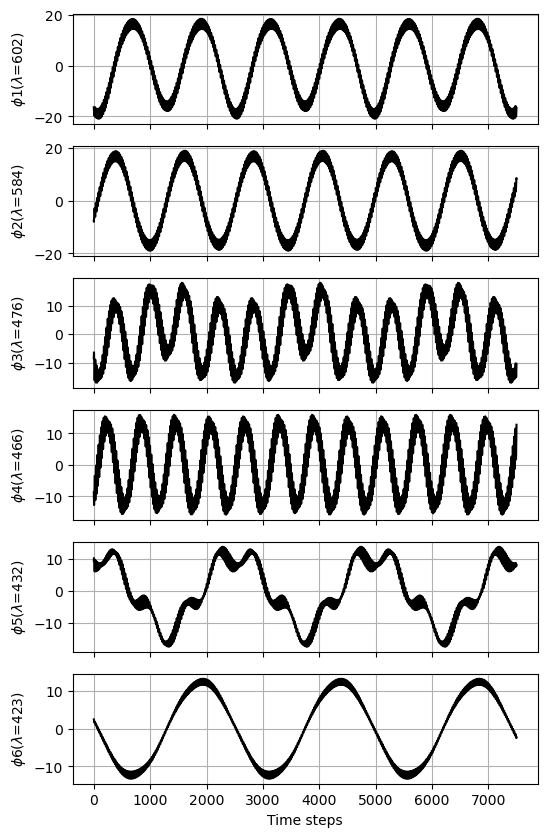

In [70]:
fig, ax = plt.subplots(nrows=6,sharex=True, figsize=(6, 10))
for _ in range(6):
    ax[_].plot(eig[_+1]*phi[:, _+1], 'k-')
    ax[_].set_ylabel(r'$\phi$' + f'{_+1}' + r'$(\lambda$' + f'={eig[_+1].real:1.0f})')
    ax[_].grid()

ax[-1].set_xlabel('Time steps')

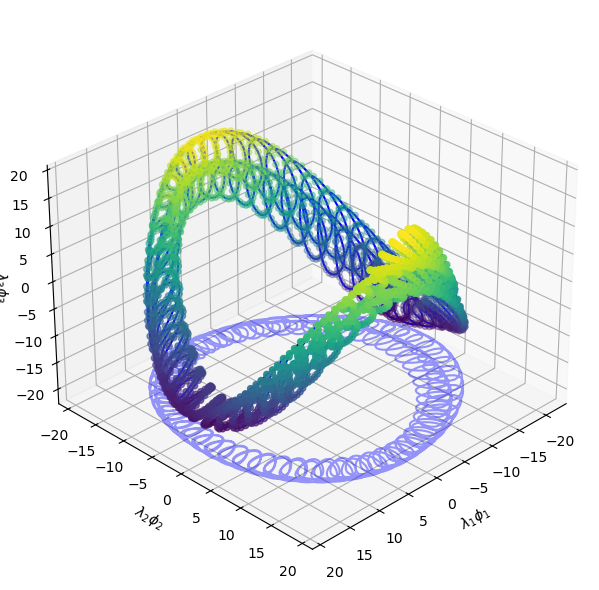

In [84]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
N = 2500
eigv = eigv.real
eig = eig.real
ax.plot(eig[1]*phi[:N, 1], eig[2]*phi[:N, 2], eig[3]*phi[:N, 3],c='b')
ax.scatter(eig[1]*phi[:N, 1], eig[2]*phi[:N, 2], eig[3]*phi[:N, 3], ".", c=eig[3]*phi[:N, 3])
ax.plot(eig[1]*phi[:N, 1], eig[2]*phi[:N, 2], -20*np.ones(N) ,c='b', alpha=0.4)
ax.view_init(elev=30, azim=45, roll=0)
ax.set_xlabel(r'$\lambda_1 \phi_1$')
ax.set_ylabel(r'$\lambda_2 \phi_2$')
ax.set_zlabel(r'$\lambda_3 \phi_3$', labelpad=0.5)
fig.tight_layout()

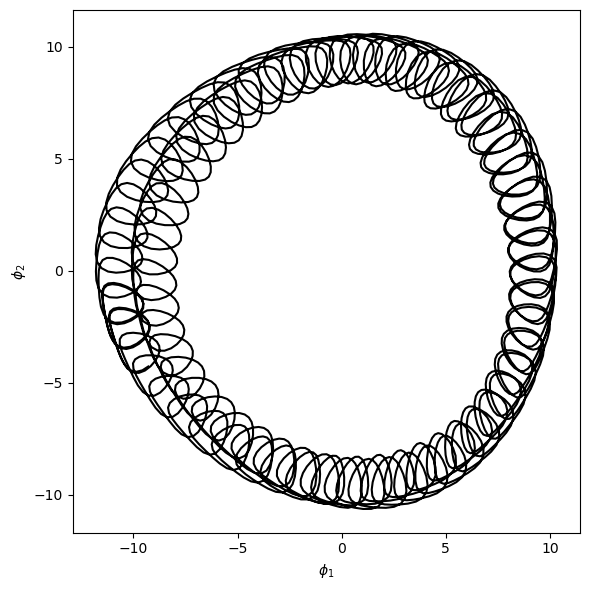

In [79]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
N = 2500
ax.plot(eig[1]*eigv[:N, 1], eig[2]*eigv[:N, 2], 'k-')
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')
fig.tight_layout()

In [1]:
import numpy as np
import polars as pl
import pickle
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter, LogLocator, LogFormatter
from matplotlib.colors import LogNorm

class NumpyCoreCompatUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module.startswith("numpy._core"):
            module = module.replace("numpy._core", "numpy.core")
        return super().find_class(module, name)

NT = 5000000
SKP = 500000
DT = 0.001
TS = 10
data = pickle.load(open(f"./ks_utils/ksdata_traveling_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
dt = data["dt"]; xx = data["x"]; tt = data["t"]
uu = data["udata"].astype(np.float64)


Noffset = 6000
Ntest = 14000
steps = Ntest
tt = tt[:Ntest]
tk = tt[::2]
truePath = uu[Noffset:Noffset+Ntest:2]
num_points = 6000

"""
    Kernel Methods (DM / RBF)
"""
mode_lst = ['diffusion', 'rbf', 'gmkrr', 'candyman','node', 'ldnet']
results = {}
for mode in mode_lst:
    results[mode] = {}

for mode in ['diffusion', 'rbf']:
    map_type = "skip-connection"
    results_path = f"./numerical_results/ks_traveling_{mode}_{num_points}_{map_type}_dt_0.02_seed_1442.pkl"
    with open(results_path, 'rb') as f:
        results_df = pickle.load(f)
    results[mode]['epsilon'] = results_df["epsilon"]
    results[mode]['lambda'] = results_df["lambda"]
    
    # results[mode]['error'] = results_df["error"].to_numpy() 
    # paths = np.zeros((Ntest//2, uu.shape[1]))

    paths = results_df['path'].squeeze()
    error = np.abs(truePath - paths)
    results[mode]['path'] = paths
    results[mode]['error'] = error
    results[mode]['rmse'] = np.sqrt(np.mean((error)**2))

"""
    GMKRR
"""
gmkrr_path = "/home/jzs6565/dm_code/dm_final/gindy/test/res/"
gmkrr_file = gmkrr_path + "ks_trf_100.dat"
with open(gmkrr_file, "rb") as file:
    gmkrr_results = pickle.load(file)
gmkrr_pred = gmkrr_results[0][::2]
gmkrr_error = np.abs(truePath - gmkrr_pred)
results['gmkrr']['path'] = gmkrr_pred
results['gmkrr']['error'] = gmkrr_error
results['gmkrr']['rmse'] = np.sqrt(np.mean((gmkrr_error)**2))

"""
    CANDYMan
"""
candyman_path = "/home/jzs6565/dm_code/dm_final/geometric_multivariate_kernel_ridge_regression/test/external/candyman_res/"
candyman_file = candyman_path + "kst.pkl"
with open(candyman_file, "rb") as file:
    res = pickle.load(file)
candyman_path = res[2][:14000:2, :64]
results['candyman']['path'] = candyman_path
candyman_error = np.abs(truePath - candyman_path)
results['candyman']['error'] = candyman_error
results['candyman']['rmse'] = np.sqrt(np.mean((candyman_error)**2))

"""
    NODE
"""
node_path = "/home/jzs6565/dm_code/dm_final/gindy/test/res/"
node_file = node_path + "ks_trf_nde.pkl"
with open(node_file, "rb") as file:
    res = NumpyCoreCompatUnpickler(file).load()
node_path = res[0][::2]
node_error = np.abs(truePath - node_path)
results['node']['path'] = node_path
results['node']['error'] = node_error
results['node']['rmse'] = np.sqrt(np.mean((node_error)**2))

"""
    LDNet
"""
ldnet_path = "/home/jzs6565/dm_code/dm_final/geometric_multivariate_kernel_ridge_regression/test/external/ldnet_res/"
ldnet_file = ldnet_path + "ks_trf_ldn.pkl"
with open(ldnet_file, "rb") as file:
    res = pickle.load(file)
ldnet_pred = res[0][::2]
ldnet_error = np.abs(truePath - ldnet_pred)
results['ldnet']['path'] = ldnet_pred
results['ldnet']['error'] = ldnet_error
results['ldnet']['rmse'] = np.sqrt(np.mean((ldnet_error)**2))

In [3]:
from sklearn.manifold import Isomap
Nm = 5000
Nt = 500
K = int(np.sqrt(Nm))
isom = Isomap(n_neighbors=K, n_components=3)

dat = uu[:Nm]
X = isom.fit_transform(dat).T
Xt = X[:, :Nt]

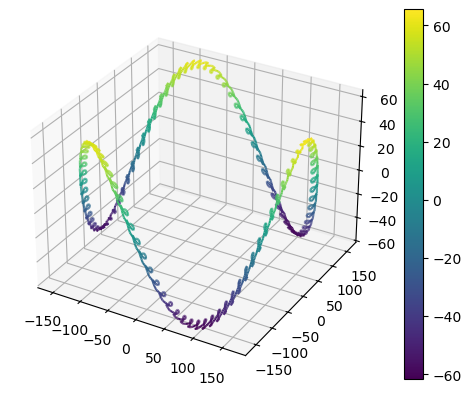

In [9]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.pyplot as plt
import numpy as np

# X shape: (3, N)
# assume X = np.vstack((x, y, z))

points = X.T.reshape(-1, 1, 3)            # (N, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)  # (N-1, 2, 3)

lc = Line3DCollection(segments, array=X[2][:-1], cmap="viridis")
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.add_collection3d(lc)

ax.set_xlim(X[0].min(), X[0].max())
ax.set_ylim(X[1].min(), X[1].max())
ax.set_zlim(X[2].min(), X[2].max())
plt.colorbar(lc, ax=ax)
plt.show()


/tmp/ipykernel_1564733/1492831494.py:91: UserWarning: Log scale: values of z <= 0 have been masked
  im_dm_err  = ax_dm_err.contourf(tk, xx, results['diffusion']['error'].T, levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
/tmp/ipykernel_1564733/1492831494.py:92: UserWarning: Log scale: values of z <= 0 have been masked
  im_rbf_err = ax_rbf_err.contourf(tk, xx, results['rbf']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
/tmp/ipykernel_1564733/1492831494.py:93: UserWarning: Log scale: values of z <= 0 have been masked
  im_gmkrr_err = ax_gmkrr_err.contourf(tk, xx, results['gmkrr']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
/tmp/ipykernel_1564733/1492831494.py:95: UserWarning: Log scale: values of z <= 0 have been masked
  im_candyman_err = ax_candyman_err.contourf(tk, xx, results['candyman']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
/tmp/ipykernel_1564733/14928

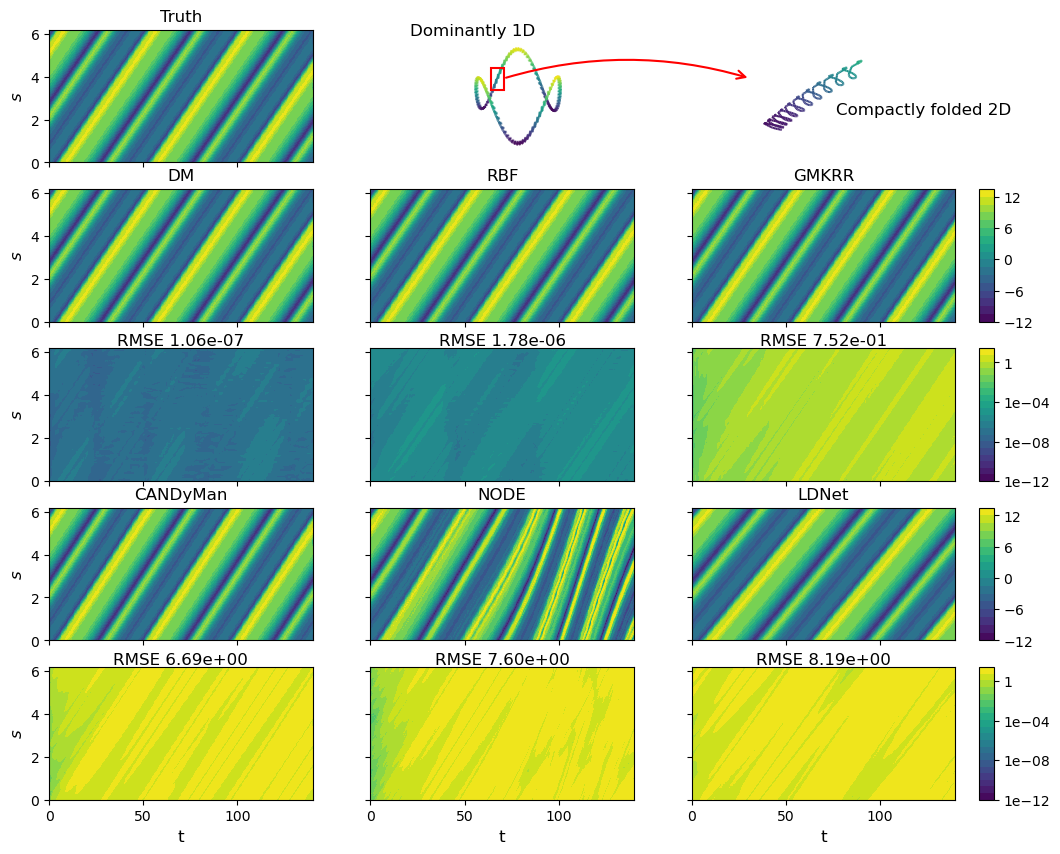

In [5]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.colors import Normalize

fig = plt.figure(figsize=(12, 10))
gs  = fig.add_gridspec(nrows=5, ncols=3, right=0.88, hspace=0.20, wspace=0.22)

fontsize=12

# Truth
ax_truth    = fig.add_subplot(gs[0, 0])
gs_top = gs[0, 1:].subgridspec(1, 2, wspace=0.0)

ax_im_full  = fig.add_subplot(gs_top[0, 0], projection='3d')
ax_im_zoom  = fig.add_subplot(gs_top[0, 1], projection='3d')


# DM / RBF/ GMKRR
ax_dm_skip  = fig.add_subplot(gs[1, 0], sharex=ax_truth, sharey=ax_truth)
ax_rbf_skip = fig.add_subplot(gs[1, 1], sharex=ax_truth, sharey=ax_truth)
ax_gmkrr = fig.add_subplot(gs[1, 2], sharex=ax_truth, sharey=ax_truth)

# CANDYMan / NODE/ LDNet
ax_candyman = fig.add_subplot(gs[3, 0], sharex=ax_truth, sharey=ax_truth)
ax_node = fig.add_subplot(gs[3, 1], sharex=ax_truth, sharey=ax_truth)
ax_ldnet = fig.add_subplot(gs[3, 2], sharex=ax_truth, sharey=ax_truth)

# Error 
ax_dm_err  = fig.add_subplot(gs[2, 0], sharex=ax_truth, sharey=ax_truth)
ax_rbf_err = fig.add_subplot(gs[2, 1], sharex=ax_truth, sharey=ax_truth)
ax_gmkrr_err = fig.add_subplot(gs[2, 2], sharex=ax_truth, sharey=ax_truth)

ax_candyman_err = fig.add_subplot(gs[4, 0], sharex=ax_truth, sharey=ax_truth)
ax_node_err = fig.add_subplot(gs[4, 1], sharex=ax_truth, sharey=ax_truth)
ax_ldnet_err = fig.add_subplot(gs[4, 2], sharex=ax_truth, sharey=ax_truth)



im_truth = ax_truth.contourf(tk, xx, truePath.T, levels=21)
truth_levels = im_truth.levels

im_dm_skip  = ax_dm_skip.contourf(tk, xx, results['diffusion']['path'].T, levels=truth_levels)
im_rbf_skip = ax_rbf_skip.contourf(tk, xx, results['rbf']['path'].T,       levels=truth_levels)
im_gmkrr = ax_gmkrr.contourf(tk, xx, results['gmkrr']['path'].T,       levels=truth_levels)

im_candyman  = ax_candyman.contourf(tk, xx, results['candyman']['path'].T, levels=truth_levels)
im_candyman  = ax_node.contourf(tk, xx, results['node']['path'].T, levels=truth_levels)
im_ldnet = ax_ldnet.contourf(tk, xx, results['ldnet']['path'].T,       levels=truth_levels)

# isomap
icmap = plt.get_cmap("viridis")
norm = Normalize(vmin=X[2].min(), vmax=X[2].max())

# Full trajectory (top middle)
points = X.T.reshape(-1, 1, 3)                      # (N, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)  # (N-1, 2, 3)

lc_full = Line3DCollection(segments, cmap=icmap, norm=norm)
lc_full.set_array(X[2][:-1])                        # colors along the line
ax_im_full.add_collection3d(lc_full)
ax_im_full.set_xlim(X[0].min(), X[0].max())
ax_im_full.set_ylim(X[1].min(), X[1].max())
ax_im_full.set_zlim(X[2].min(), X[2].max())
ax_im_full.axis('off')

# Zoomed trajectory (top right)
points_t = Xt.T.reshape(-1, 1, 3)
segments_t = np.concatenate([points_t[:-1], points_t[1:]], axis=1)

lc_zoom = Line3DCollection(segments_t, cmap=icmap, norm=norm)
lc_zoom.set_array(Xt[2][:-1])                       # still uses same norm
ax_im_zoom.add_collection3d(lc_zoom)
ax_im_zoom.axis('off')

err_arrays = [
    np.asarray(results['diffusion']['error']),
    np.asarray(results['rbf']['error']),
    np.asarray(results['gmkrr']['error']),
    np.asarray(results['candyman']['error']),
    np.asarray(results['node']['error']),
    np.asarray(results['ldnet']['error'])
]
vmax_err = max(float(np.nanmax(e)) for e in err_arrays if e.size)
def _min_pos(a):
    a = np.asarray(a)
    a_pos = a[(a > 0) & np.isfinite(a)]
    return float(a_pos.min()) if a_pos.size else np.inf
min_pos = min(_min_pos(e) for e in err_arrays)
vmin_err = 1e-12 if not np.isfinite(min_pos) else max(min_pos, 1e-12)

levels_err = np.logspace(np.log10(vmin_err), np.log10(vmax_err), 21)
im_dm_err  = ax_dm_err.contourf(tk, xx, results['diffusion']['error'].T, levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
im_rbf_err = ax_rbf_err.contourf(tk, xx, results['rbf']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
im_gmkrr_err = ax_gmkrr_err.contourf(tk, xx, results['gmkrr']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))

im_candyman_err = ax_candyman_err.contourf(tk, xx, results['candyman']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
im_node_err = ax_node_err.contourf(tk, xx, results['node']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
im_ldnet_err = ax_ldnet_err.contourf(tk, xx, results['ldnet']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))


ax_truth.set_title('Truth')
ax_dm_skip.set_title('DM'); ax_rbf_skip.set_title('RBF'); ax_gmkrr.set_title('GMKRR')
ax_candyman.set_title('CANDyMan'); ax_node.set_title('NODE'); ax_ldnet.set_title('LDNet')

ax_dm_err.set_title(f"RMSE {results['diffusion']['rmse']:.2e}", fontsize=12, pad=2)
ax_rbf_err.set_title(f"RMSE {results['rbf']['rmse']:.2e}",     fontsize=12, pad=2)
ax_gmkrr_err.set_title(f"RMSE {results['gmkrr']['rmse']:.2e}",     fontsize=12, pad=2)

ax_candyman_err.set_title(f"RMSE {results['candyman']['rmse']:.2e}",     fontsize=12, pad=2)
ax_node_err.set_title(f"RMSE {results['node']['rmse']:.2e}",     fontsize=12, pad=2)
ax_ldnet_err.set_title(f"RMSE {results['ldnet']['rmse']:.2e}",     fontsize=12, pad=2)


ax_dm_skip.set_ylabel('$s$', fontsize=fontsize)
ax_dm_err.set_ylabel('$s$', fontsize=fontsize)
ax_candyman.set_ylabel('$s$', fontsize=fontsize)
ax_candyman_err.set_ylabel('$s$', fontsize=fontsize)
for ax in (ax_dm_err, ax_rbf_err):
    ax.set_xlabel('$t$', fontsize=fontsize)

ax_truth.set_xlim(tt[0], tt[-1])
ax_truth.set_xticks([0.0, 50.0, 100.0])


all_axes = [ax_truth, ax_dm_skip, ax_rbf_skip, ax_dm_err, ax_rbf_err]
for ax in all_axes:
    ax.tick_params(labelbottom=True, labelleft=True, bottom=True, left=True)

# plt.tight_layout(rect=[0, 0, 0.88, 0.98])

# def widen_axis(ax, expand_left=0.0, expand_right=0.0):
#     pos = ax.get_position()
#     new_x0    = pos.x0 - expand_left
#     new_width = pos.width + expand_left + expand_right
#     ax.set_position([new_x0, pos.y0, new_width, pos.height])

# widen_axis(ax_im_zoom, expand_left=0.1, expand_right=0.01)
# widen_axis(ax_im_full, expand_left=0.01, expand_right=0.01)


def prettify_cbar(cb, nbins=6, ticks=None):
    cb.locator = MaxNLocator(nbins=nbins, prune=None, steps=[1, 2, 2.5, 5, 10])
    fmt = ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((-2, 3))
    cb.formatter = fmt
    if ticks is not None:
        cb.set_ticks(ticks)
    cb.update_ticks()

def prettify_cbar_log(cb, base=10):
    cb.locator   = LogLocator(base=base)
    cb.formatter = LogFormatter(base=base)
    cb.update_ticks()

def add_row_colorbar(fig, row_axes, mappable, left=0.90, width=0.012):
    # compute row bounds from actual (tight) positions
    bottoms = [ax.get_position().y0 for ax in row_axes]
    tops    = [ax.get_position().y1 for ax in row_axes]
    bottom, top = min(bottoms), max(tops)
    height = top - bottom
    cax = fig.add_axes([left, bottom, width, height])
    return fig.colorbar(mappable, cax=cax)

axes_shared = [ax_truth, 
               ax_dm_skip, ax_rbf_skip, ax_gmkrr, 
               ax_candyman, ax_node, ax_ldnet,
               ax_dm_err, ax_rbf_err, ax_gmkrr_err,
               ax_candyman_err, ax_node_err, ax_ldnet_err]
for ax in axes_shared:
    ax.set_xlim(ax_truth.get_xlim())
    ax.set_ylim(ax_truth.get_ylim())
    ax.set_autoscale_on(False)
    ax.label_outer()

ax_candyman_err.set_xlabel("t", fontsize=12)
ax_node_err.set_xlabel("t", fontsize=12)
ax_ldnet_err.set_xlabel("t", fontsize=12)

row0_axes = [ax_truth]
row2_axes = [ax_dm_skip, ax_rbf_skip, ax_gmkrr]
row3_axes = [ax_dm_err, ax_rbf_err, ax_gmkrr_err]
row4_axes = [ax_candyman, ax_node, ax_ldnet]
row5_axes = [ax_candyman_err, ax_node_err, ax_ldnet_err]

# cb0 = add_row_colorbar(fig, row0_axes, im_truth,   left=0.90, width=0.012)
cb2 = add_row_colorbar(fig, row2_axes, im_dm_skip, left=0.90, width=0.012)
cb3 = add_row_colorbar(fig, row3_axes, im_dm_err, left=0.90, width=0.012)
cb4 = add_row_colorbar(fig, row4_axes, im_candyman, left=0.90, width=0.012)
cb5 = add_row_colorbar(fig, row5_axes, im_candyman_err, left=0.90, width=0.012)
ax_truth.set_ylabel('$s$', fontsize=fontsize)

# ticks = [-15, -12, -9, -6, -3, 0, 3, 6, 9, 12, 15]
ticks = [-12, -6, 0, 6, 12]

# prettify_cbar(cb0, nbins=5, ticks=ticks)
prettify_cbar(cb2, nbins=5, ticks=ticks)
prettify_cbar(cb4, nbins=5, ticks=ticks)
prettify_cbar_log(cb3, base=10)
prettify_cbar_log(cb5, base=10)

plt.text(
    -0.3, 1.05, "Dominantly 1D",
    transform=ax_im_full.transAxes,
    ha="left", va="top",
    fontsize=12,
)
plt.text(
    0.7, 0.45, "Compactly folded 2D",
    transform=ax_im_zoom.transAxes,
    ha="left", va="top",
    fontsize=12,
)

ax_im_full.text2D(
    0.34, 0.6, " ",
    transform=ax_im_full.transAxes,
    bbox=dict(
        boxstyle="square",
        edgecolor="red",
        facecolor="none",
        linewidth=1.5,
    ),
)

bbox_zoom = ax_im_zoom.get_position()
bbox_full = ax_im_full.get_position()

x_start = bbox_zoom.x1 - 0.31
y_start = 0.5 * bbox_zoom.y0 + 0.52 * bbox_zoom.y1

x_end = bbox_full.x0 + 0.25
y_end = 0.5 * bbox_full.y0 + 0.52 * bbox_full.y1

import matplotlib.patches as mpatches
arrow = mpatches.FancyArrowPatch(
    (x_start, y_start),
    (x_end, y_end),
    transform=fig.transFigure,
    arrowstyle="->",
    connectionstyle="arc3,rad=-0.15",
    mutation_scale=15,
    linewidth=1.5,
    color="red",
)

fig.add_artist(arrow)

fig.savefig(f"journal_pics/ks_traveling_prediction_results.png",
            bbox_inches="tight", dpi=600, transparent=True)



## Chaotic

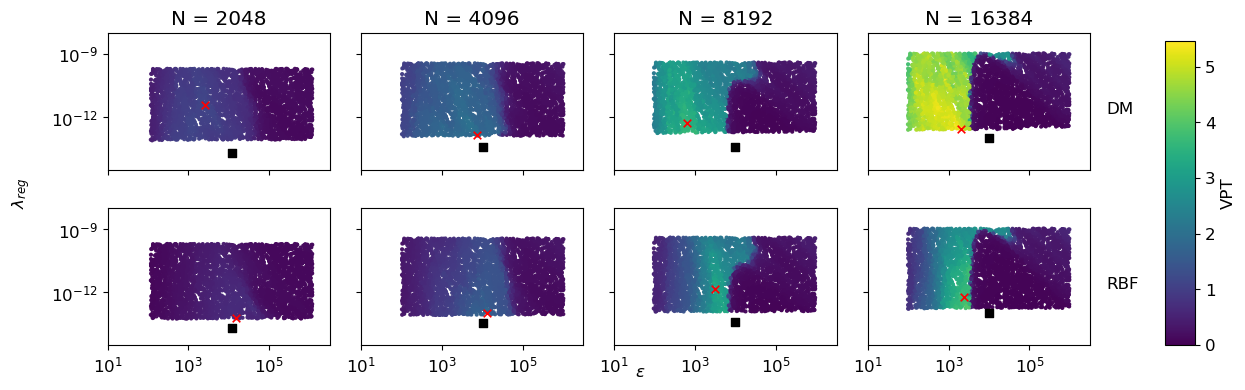

In [4]:
import os
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import matplotlib as mpl

RESULTS_DIR = "numerical_results"
TITLE = "ks_chaotic"

N_LIST = [2048, 4096, 8192, 16384]

ROW_ORDER = [
    ("diffusion", "direct"),
    # ("diffusion", "skip-connection"),
    ("rbf",       "direct"),
    # ("rbf",       "skip-connection"),
]
MODE_LABEL = {"diffusion": "DM", "rbf": "RBF"}

MT_LABEL = {"direct": "Direct", "skip-connection": "Skip\nConnection"}

cmap = "viridis"
point_size = 4
best_size = 22
alpha_points = 0.95
devices = 4

plt.rcParams.update({"font.size": 12})

def cv_path(title: str, mode: str, N: int, map_type: str) -> str:
    return os.path.join(RESULTS_DIR, f"ks_chaotic_cv_{mode}_{N}_{map_type}.parquet")

cv_data = {}  # (mode, map_type, N) -> dict(eps=..., lam=..., tau=...)
vpt_min, vpt_max = np.inf, -np.inf
eps_min, eps_max = np.inf, -np.inf
lam_min, lam_max = np.inf, -np.inf

for mode, map_type in ROW_ORDER:
    for N in N_LIST:
        fp = cv_path(TITLE, mode, N, map_type)
        try:
            df = pl.read_parquet(fp)
        except:
            continue
        eps = df["epsilon"].to_numpy()
        lam = df["lambda"].to_numpy()
        vpt = df["vpts"].to_numpy()
        lamm = df["lambda_min"][0]
        epsc = df["epsilon_c"][0]
        valid = (
            np.isfinite(vpt) & (vpt >= 0)
        )
        if not valid.any():
            continue

        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]
        cv_data[(mode, map_type, N)] = dict(eps=eps, lam=lam, vpt=vpt, lamm=lamm, epsc=epsc)
        vpt_min = min(vpt_min, float(np.min(vpt_v)))
        vpt_max = max(vpt_max, float(np.max(vpt_v)))
        eps_min = min(eps_min, float(eps_v.min()))
        eps_max = max(eps_max, float(eps_v.max()))
        lam_min = min(lam_min, float(lam_v.min()))
        lam_max = max(lam_max, float(lam_v.max()))


if not np.isfinite(vpt_min) or not np.isfinite(vpt_max):
    raise RuntimeError("No valid τ_f values found in CV files; cannot plot.")

norm = mpl.colors.Normalize(vmin=vpt_min, vmax=vpt_max)

def pad_log_bounds(lo, hi, pad=0.05):
    return lo * (1 - pad), hi * (1 + pad)

eps_lo, eps_hi = pad_log_bounds(eps_min, eps_max)
lam_lo, lam_hi = pad_log_bounds(lam_min, lam_max)

rows, cols = len(ROW_ORDER), len(N_LIST)
fig, axs = plt.subplots(rows, cols, figsize=(15, 4), sharex=False, sharey=False)

RIGHT   = 0.78   
WSPACE  = 0.14  
HSPACE  = 0.28 
GAP     = 0.13
CBAR_W  = 0.028
BOTTOM, TOP = 0.12, 0.90

if rows == 1 and cols == 1:
    axs = np.array([[axs]])
elif rows == 1:
    axs = np.array([axs])
elif cols == 1:
    axs = axs.reshape(rows, 1)

fig.subplots_adjust(right=RIGHT, wspace=WSPACE, hspace=HSPACE, bottom=BOTTOM, top=TOP)

sc_last = None

for r, (mode, map_type) in enumerate(ROW_ORDER):
    for c, N in enumerate(N_LIST):
        ax = axs[r, c]

        if r == 0:
            ax.set_title(f"N = {N}")

        if c == cols - 1:
            ax.set_ylabel(f"{MODE_LABEL[mode]}", rotation=0,
                          labelpad=12, ha="left")
            ax.yaxis.set_label_position("right")

        key = (mode, map_type, N)
        if key not in cv_data:
            ax.set_xscale("log"); ax.set_yscale("log")
            ax.set_xlim(eps_lo, eps_hi); ax.set_ylim(lam_lo, lam_hi)
            ax.grid(True, which="both", alpha=0.25)
            continue

        D = cv_data[key]
        eps = D["eps"]; lam = D["lam"]; vpt = D["vpt"]
        eps_c = D["epsc"]
        lam_m = D["lamm"]

        valid = (
            np.isfinite(vpt) & (vpt > 0)
        )
        if not valid.any():
            continue

        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]

        sc = ax.scatter(
            eps_v, lam_v,
            c=vpt_v,
            cmap=cmap,
            norm=norm,
            s=point_size, alpha=alpha_points
        )
        ax.scatter(eps_c, 10**lam_m, c="black", marker='s', s=30)
        sc_last = sc

        idx = np.nanargmax(vpt_v)
        best_eps = eps_v[idx]
        best_lam = lam_v[idx]

        ax.scatter(best_eps, best_lam, c="red",
                    marker="x", s=30, linewidths=1.2)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([10**(1), 10**(6.5)])
        ax.set_ylim(10**(-14.5), 10**(-8))

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
x0 = fig.subplotpars.right + 0.05
cbar_ax = fig.add_axes([x0, 0.12, 0.02, 0.76])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel("VPT", fontsize=12)

fig.text(0.48, 0.04, r"$\epsilon$", ha="center", fontsize=12)
fig.text(0.06, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical", fontsize=12)


x_locator = LogLocator(base=10, numticks=3)  # adjust numticks to taste
y_locator = LogLocator(base=10, numticks=3)


for ax in axs.flat:

    ax.tick_params(
        axis="x",
        which="both",
        bottom=True,
        top=False,
        labelbottom=False
    )
    ax.tick_params(
        axis="y",
        which="both",
        left=True, 
        right=False,
        labelleft=False
    )

    ax.xaxis.set_major_locator(x_locator)
    ax.yaxis.set_major_locator(y_locator)
    ax.minorticks_off()

for r in range(2):
    ax = axs[r, 0]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

for c in range(4):
    ax = axs[1, c]
    ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
    ax.xaxis.set_major_locator(x_locator)


fig.savefig("./journal_pics/ks_chaotic_cv_results.png", dpi=600, bbox_inches="tight", transparent=True)

In [ ]:
import os
import re
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import polars as pl
from matplotlib.ticker import LogLocator, LogFormatterMathtext

RESULTS_DIR = "./numerical_results"

NUM_POINTS_WHITELIST = [2048, 4096, 8192]

TITLE_PREFIX = "ks_chaotic_test_result_"
FNPAT = re.compile(
    r"^ks_chaotic_test_result_"
    r"(?P<mode>[^_]+)_(?P<map>[^_]+)_(?P<num>\d+)\.pkl$"
)
MODE_ORDER = ["diffusion", "rbf"]
MODE_SHORT = {"diffusion": "DM", "rbf": "RBF"}
MAP_TYPES  = ("direct")#, "skip-connection")

MAP_LABEL = {
    "direct": "direct",
    "skip-connection": "skip",
}


def discover_results(results_dir=RESULTS_DIR, whitelist=NUM_POINTS_WHITELIST, map_filter=None):

    items = []
    if not os.path.isdir(results_dir):
        raise FileNotFoundError(f"Results directory not found: {results_dir}")
    for fn in os.listdir(results_dir):
        if not fn.startswith(TITLE_PREFIX) or not fn.endswith(".pkl"):
            continue
        m = FNPAT.match(fn)
        if not m:
            continue
        mode = m.group("mode")
        map_type = m.group("map")
        num_points = int(m.group("num"))

        if map_filter is not None and map_type != map_filter:
            continue
        if whitelist and num_points not in whitelist:
            continue

        path = os.path.join(results_dir, fn)
        items.append((mode, map_type, num_points, path))

    if not items:
        flt = f" and map_type='{map_filter}'" if map_filter else ""
        raise RuntimeError(
            f"No files with N in {whitelist}{flt} found under pattern "
            f"'{TITLE_PREFIX}{{mode}}_{{map}}_{{num}}.pkl' in {results_dir}."
        )

    if map_filter:
        found_N = {n for *_, n, _ in items}
        missing = [n for n in whitelist if n not in found_N]
        if missing:
            warnings.warn(f"Requested N not found for map_type='{map_filter}': {missing}")
    return items


def load_perf(path):
    with open(path, "rb") as f:
        perf = pickle.load(f)
    vpts = np.asarray(perf["vpts"], dtype=float)
    tau  = np.asarray(perf["tau_fs"], dtype=float)
    return vpts, tau


def build_data_by_maptype(found):
    data = {}
    for mode, map_type, num_points, path in found:
        v, t = load_perf(path)
        data.setdefault(map_type, {}).setdefault(mode, {})[num_points] = (v, t)
    return data


def assemble_best_by_num(
    data_by_maptype,
    mode_order=MODE_ORDER,
    whitelist=NUM_POINTS_WHITELIST,
    map_types=MAP_TYPES,
):
    labels_base, vpt_list, tau_list = [], [], []

    for mode in mode_order:
        for N in whitelist:
            best_score = -np.inf
            best_v = None
            best_t = None
            best_mt = None

            for mt in map_types:
                if mt not in data_by_maptype:
                    continue
                if mode not in data_by_maptype[mt]:
                    continue
                if N not in data_by_maptype[mt][mode]:
                    continue

                v, t = data_by_maptype[mt][mode][N]
                score = np.nanmean(v)
                if score > best_score:
                    best_score = score
                    best_v = v
                    best_t = t
                    best_mt = mt

            if best_v is not None:
                short = MODE_SHORT.get(mode, mode)
                mt_str = MAP_LABEL.get(best_mt, best_mt)
                labels_base.append(f"{short} ({mt_str})\nN={N}")
                vpt_list.append(best_v)
                tau_list.append(best_t)
                print(f"Selected map_type='{best_mt}' for mode={mode}, N={N} "
                      f"(mean VPT={best_score:.3f})")

    return labels_base, vpt_list, tau_list


# ------------------------ Violin plotting ---------------------
def plot_vpt_for_maptype(labels_base, vpt_list, *,
                         digits=2, widths=0.9, color='C0',
                         logy=False, show_means_markers=True):
    n = len(labels_base)
    x = np.arange(1, n + 1)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    vp = ax.violinplot(
        vpt_list,
        positions=x,
        widths=widths,
        showmeans=False,
        showextrema=False,
        showmedians=False,
    )

    for body in vp['bodies']:
        body.set_facecolor(color)
        body.set_edgecolor('black')
        body.set_alpha(0.85)
        body.set_linewidth(1)

    # Mean VPT as a short horizontal line
    vpt_mean = np.array([np.nanmean(v) for v in vpt_list])

    if show_means_markers:
        for xi, mv in zip(x, vpt_mean):
            ax.hlines(
                mv,
                xi - 0.12,
                xi + 0.12,
                color='black',
                linewidth=2,
                zorder=5,
            )

    if logy:
        ax.set_yscale('log')
    ax.set_ylabel("VPT")

    # Tick labels: include E[VPT]
    labels_with_means = []
    for base, mv in zip(labels_base, vpt_mean):
        labels_with_means.append(
            f"{base}\n"
            r"$\mathbb{E}[\mathrm{VPT}]=" + f"{mv:.{digits}f}$"
        )

    ax.set_xticks(x)
    ax.set_xticklabels(labels_with_means, rotation=0, fontsize=9)
    ax.grid(True, axis="y", alpha=0.25)

    fig.tight_layout()
    return fig

digits = 2
logy = True

found = discover_results(map_filter=None)
data_by_maptype = build_data_by_maptype(found)

labels_base, vpt_list, tau_list = assemble_best_by_num(data_by_maptype)
if not labels_base:
    raise RuntimeError("No plottable data after best-map selection.")

fig = plot_vpt_for_maptype(
    labels_base, vpt_list,
    digits=digits, logy=logy, show_means_markers=True
)


# fig.savefig(
#     "./journal_pics/ks_chaotic_violin_best_per_N_logy_cp.png",
#     dpi=600, bbox_inches="tight", transparent=True
# )



RuntimeError: No plottable data after best-map selection.

mode = rbf, map_type = direct, N = 4096 | vpt mean = 1.54327, vpt std = 0.7581529729942368, max = 4.6698, min = 0.3225, n = 0 reached maximum
mode = rbf, map_type = direct, N = 16384 | vpt mean = 4.441728, vpt std = 1.5425911983335052, max = 10.75, min = 1.5394, n = 1 reached maximum
mode = diffusion, map_type = direct, N = 4096 | vpt mean = 1.6317984, vpt std = 0.8263654242993471, max = 4.9794, min = 0.3096, n = 0 reached maximum
mode = rbf, map_type = direct, N = 8192 | vpt mean = 2.7066006, vpt std = 1.2172231304816878, max = 7.6411, min = 0.4644, n = 0 reached maximum
mode = diffusion, map_type = direct, N = 2048 | vpt mean = 0.8591314, vpt std = 0.5248505596015308, max = 3.8184, min = 0.1075, n = 0 reached maximum
mode = rbf, map_type = direct, N = 2048 | vpt mean = 0.8317318, vpt std = 0.5002376963891866, max = 3.1691, min = 0.0946, n = 0 reached maximum
mode = diffusion, map_type = direct, N = 16384 | vpt mean = 5.032934999999999, vpt std = 1.748640790990248, max = 10.75, min = 

/tmp/ipykernel_2966625/1385665256.py:181: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([-1, yline+5])


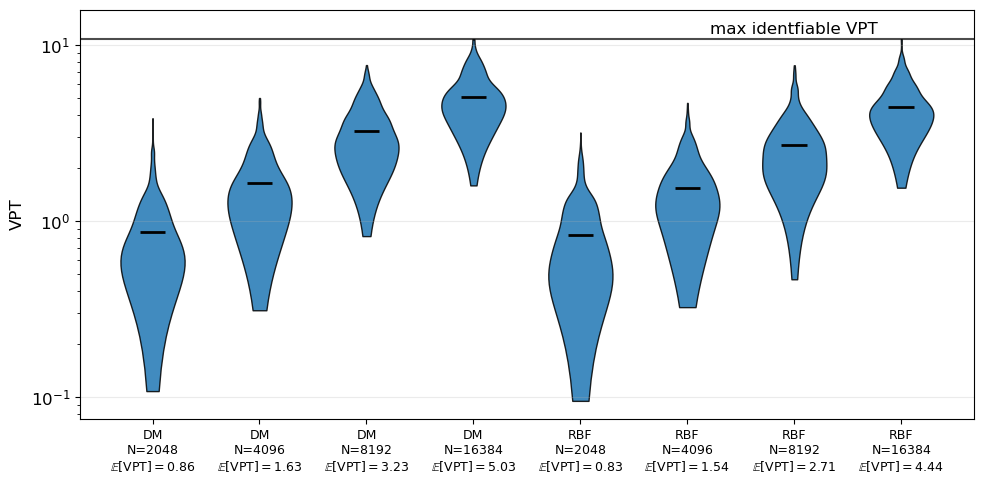

In [6]:
import os
import re
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import polars as pl
from matplotlib.ticker import LogLocator, LogFormatterMathtext

RESULTS_DIR = "./numerical_results"

NUM_POINTS_WHITELIST = [2048, 4096, 8192, 16384]

TITLE_PREFIX = "ks_chaotic_test_result_"
FNPAT = re.compile(
    r"^ks_chaotic_test_result_"
    r"(?P<mode>[^_]+)_(?P<map>[^_]+)_(?P<num>\d+)\.pkl$"
)
MODE_ORDER = ["diffusion", "rbf"]
MODE_SHORT = {"diffusion": "DM", "rbf": "RBF"}

# ---- choose ONE map type here ----
MAP_TYPE = "direct"          # or "skip-connection"

MAP_LABEL = {
    "direct": "direct",
    "skip-connection": "skip",
}


def discover_results(results_dir=RESULTS_DIR, whitelist=NUM_POINTS_WHITELIST, map_filter=None):

    items = []
    if not os.path.isdir(results_dir):
        raise FileNotFoundError(f"Results directory not found: {results_dir}")
    for fn in os.listdir(results_dir):
        if not fn.startswith(TITLE_PREFIX) or not fn.endswith(".pkl"):
            continue
        m = FNPAT.match(fn)
        if not m:
            continue
        mode = m.group("mode")
        map_type = m.group("map")
        num_points = int(m.group("num"))

        if map_filter is not None and map_type != map_filter:
            continue
        if whitelist and num_points not in whitelist:
            continue

        path = os.path.join(results_dir, fn)
        items.append((mode, map_type, num_points, path))

    if not items:
        flt = f" and map_type='{map_filter}'" if map_filter else ""
        raise RuntimeError(
            f"No files with N in {whitelist}{flt} found under pattern "
            f"'{TITLE_PREFIX}{{mode}}_{{map}}_{{num}}.pkl' in {results_dir}."
        )

    if map_filter:
        found_N = {n for *_, n, _ in items}
        missing = [n for n in whitelist if n not in found_N]
        if missing:
            warnings.warn(f"Requested N not found for map_type='{map_filter}': {missing}")
    return items


def load_perf(path):
    with open(path, "rb") as f:
        perf = pickle.load(f)
    vpts = np.asarray(perf["vpts"], dtype=float)
    tau  = np.asarray(perf["tau_fs"], dtype=float)
    return vpts, tau


def build_data_by_maptype(found):
    data = {}
    for mode, map_type, num_points, path in found:
        v, t = load_perf(path)
        count = np.sum(v == 10.75)
        print(f"mode = {mode}, map_type = {map_type}, N = {num_points} | vpt mean = {np.mean(v)}, vpt std = {np.std(v)}, max = {np.max(v)}, min = {np.min(v)}, n = {count} reached maximum")
        data.setdefault(map_type, {}).setdefault(mode, {})[num_points] = (v, t)
    return data


def assemble_fixed_maptype(
    data_by_maptype,
    map_type=MAP_TYPE,
    mode_order=MODE_ORDER,
    whitelist=NUM_POINTS_WHITELIST,
):
    """
    Use a single, fixed map_type (no 'best over map_types' logic).
    """
    labels_base, vpt_list, tau_list = [], [], []

    if map_type not in data_by_maptype:
        raise RuntimeError(f"map_type='{map_type}' not found in data_by_maptype")

    for mode in mode_order:
        for N in whitelist:
            if mode not in data_by_maptype[map_type]:
                continue
            if N not in data_by_maptype[map_type][mode]:
                continue

            v, t = data_by_maptype[map_type][mode][N]
            short = MODE_SHORT.get(mode, mode)
            # mt_str = MAP_LABEL.get(map_type, map_type)
            labels_base.append(f"{short}\nN={N}")
            vpt_list.append(v)
            tau_list.append(t)

    return labels_base, vpt_list, tau_list


def plot_vpt_for_maptype(labels_base, vpt_list, *,
                         digits=2, widths=0.6, color='C0',
                         logy=False, show_means_markers=True):
    n = len(labels_base)
    x = np.arange(1, n + 1)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    vp = ax.violinplot(
        vpt_list,
        positions=x,
        widths=widths,
        showmeans=False,
        showextrema=False,
        showmedians=False,
    )

    for body in vp['bodies']:
        body.set_facecolor(color)
        body.set_edgecolor('black')
        body.set_alpha(0.85)
        body.set_linewidth(1)

    # Mean VPT as a short horizontal line
    vpt_mean = np.array([np.nanmean(v) for v in vpt_list])

    if show_means_markers:
        for xi, mv in zip(x, vpt_mean):
            ax.hlines(
                mv,
                xi - 0.12,
                xi + 0.12,
                color='black',
                linewidth=2,
                zorder=5,
            )

    if logy:
        ax.set_yscale('log')
    ax.set_ylabel("VPT")

    # Tick labels: include E[VPT]
    labels_with_means = []
    for base, mv in zip(labels_base, vpt_mean):
        labels_with_means.append(
            f"{base}\n"
            r"$\mathbb{E}[\mathrm{VPT}]=" + f"{mv:.{digits}f}$"
        )

    ax.set_xticks(x)
    ax.set_xticklabels(labels_with_means, rotation=0, fontsize=9)
    ax.grid(True, axis="y", alpha=0.25)


    yline = 250 * 0.043
    ax.axhline(
        y=yline,
        color="k",
        linewidth=1.5,
        alpha=0.7,
        linestyle="-"
    )
    ax.set_ylim([-1, yline+5])
    ax.text(
        7,
        yline + 0.3,
        "max identfiable VPT",
        ha="center",
        va="bottom",
        color="k",
    )

    fig.tight_layout()
    return fig

digits = 2
logy = True

found = discover_results(map_filter=MAP_TYPE)
data_by_maptype = build_data_by_maptype(found)

labels_base, vpt_list, tau_list = assemble_fixed_maptype(data_by_maptype, map_type=MAP_TYPE)
if not labels_base:
    raise RuntimeError("No plottable data for the chosen map_type.")

fig = plot_vpt_for_maptype(
    labels_base, vpt_list,
    digits=digits, logy=logy, show_means_markers=True
)

fig.savefig(
    "./journal_pics/ks_chaotic_violin_logy.png",
    dpi=600, bbox_inches="tight", transparent=True
)


In [29]:
import os
import re
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import polars as pl
import general_utils
import cupy as cp

NT = 15_000_000
SKP = 500_000
DT = 0.01
TS = 10
data = pickle.load(open(f"./ks_utils/ksdata_chaotic_training_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
dt = data["dt"]
xx = data["x"]
uu = data["udata"].astype(np.float64)
Nx, Nt = len(xx), len(data["t"])
assert uu.shape == (Nt, Nx)

num_points = 2048 #4096
steps = 2500
test_trials = 500
test_idx = 307

data_train = np.ascontiguousarray(uu[:num_points])

NT = 12_500_000
SKP = 500_000
DT = 0.01
TS = 10
test_load = pickle.load(open(f"./ks_utils/ksdata_chaotic_test_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
uu_test = test_load["udata"].astype(np.float64)
test = uu_test[:steps*test_trials].reshape(test_trials, steps, -1)



mode_lst = ['diffusion', 'rbf']
results = {}
for mode in mode_lst:
    results[mode] = {}


test_idx = 307
for mode in mode_lst:
    map_type = "direct"
    filename = f"./numerical_results/ks_chaotic_test_result_{mode}_{map_type}_{num_points}.pkl"

    with open(filename, "rb") as f:
        results_df = pickle.load(f)

    vpts = results_df['vpts']

    epsilon = results_df["epsilon"][test_idx]
    lambda_reg = results_df["lambda_reg"][test_idx]
    trains = results_df["train_data"][test_idx]
    pred_path = results_df["preds"][test_idx]
    

    results[mode]['truth'] = test[test_idx]
    results[mode]['path'] = pred_path
    results[mode]['error'] = np.abs(test[test_idx] - pred_path)
    results[mode]['vpt'] = vpts[test_idx]


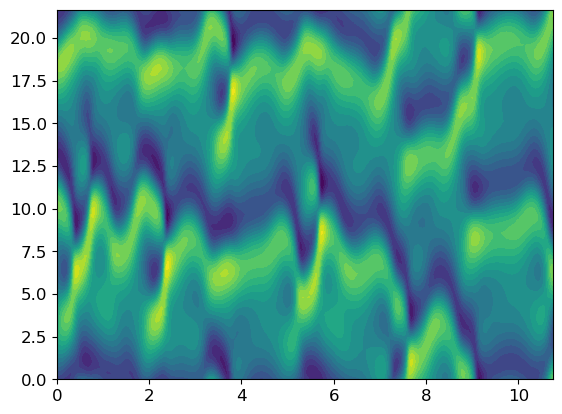

In [28]:
test_load = pickle.load(open(f"./ks_utils/ksdata_chaotic_test_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
uu_test = test_load["udata"].astype(np.float64)

test = uu_test[:steps*test_trials].reshape(test_trials, steps, -1)

fig, ax= plt.subplots()
ax.contourf(t, xx, test[307].T, levels=21)

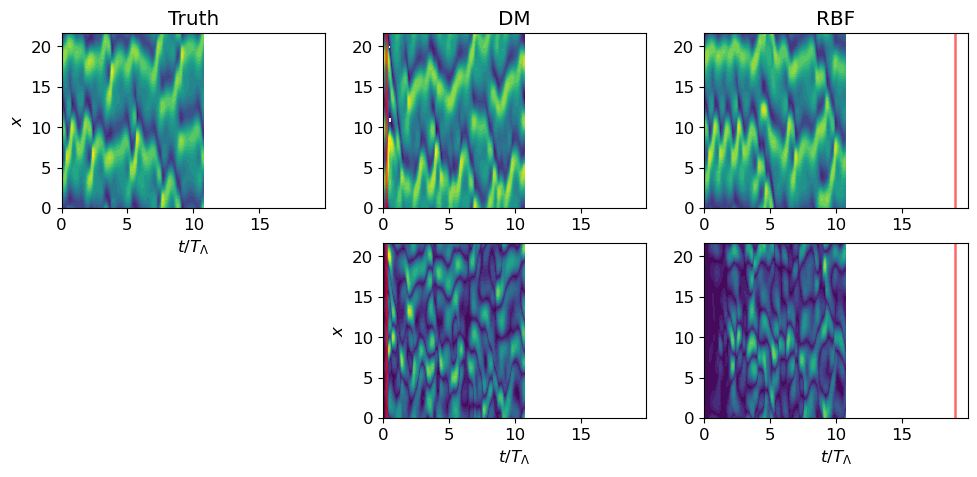

In [30]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter, LogLocator, LogFormatter


def add_row_colorbar(fig, row_axes, mappable, left=0.90, width=0.012):
    # compute row bounds from actual (tight) positions
    bottoms = [ax.get_position().y0 for ax in row_axes]
    tops    = [ax.get_position().y1 for ax in row_axes]
    bottom, top = min(bottoms), max(tops)
    height = top - bottom
    cax = fig.add_axes([left, bottom, width, height])
    return fig.colorbar(mappable, cax=cax)

def prettify_cbar(cb, nbins=6, ticks=None):
    cb.locator = MaxNLocator(nbins=nbins, prune=None, steps=[1, 2, 2.5, 5, 10])
    fmt = ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((-2, 3))
    cb.formatter = fmt
    if ticks is not None:
        cb.set_ticks(ticks)
    cb.update_ticks()

fig = plt.figure(figsize=(12, 5))
COL_VPT  = "r"
    
gs  = fig.add_gridspec(nrows=2, ncols=3, right=0.88, hspace=0.20, wspace=0.22)

dt = 0.1
steps = 2500
lye = 0.043
t = np.linspace(0, dt*(steps-1), steps) * lye
ax_truth    = fig.add_subplot(gs[0, 0])
ax_dm  = fig.add_subplot(gs[0, 1], sharex=ax_truth, sharey=ax_truth)
ax_rbf  = fig.add_subplot(gs[0, 2], sharex=ax_truth, sharey=ax_truth)

ax_dm_err  = fig.add_subplot(gs[1, 1], sharex=ax_truth, sharey=ax_truth)
ax_rbf_err = fig.add_subplot(gs[1, 2], sharex=ax_truth, sharey=ax_truth)

im_truth = ax_truth.contourf(t, xx, results['diffusion']['truth'].T, levels=21)
truth_levels = im_truth.levels
im_dm  = ax_dm.contourf(t, xx, results['diffusion']['path'].T, levels=truth_levels)
im_rbf = ax_rbf.contourf(t, xx, results['rbf']['path'].T,       levels=truth_levels)

ax_truth.set_title('Truth')
ax_dm.set_title('DM'); ax_rbf.set_title('RBF')

err_arrays = [
    np.asarray(results['diffusion']['error']),
    np.asarray(results['rbf']['error'])
]

vmax_err = max(float(np.nanmax(e)) for e in err_arrays if e.size)
levels_err = np.linspace(0, vmax_err, 21)
im_dm_err  = ax_dm_err.contourf(t, xx, results['diffusion']['error'].T, levels=levels_err)
im_rbf_err = ax_rbf_err.contourf(t, xx, results['rbf']['error'].T,       levels=levels_err)


axes_shared = [ax_truth, 
            ax_dm, ax_rbf,
            ax_dm_err, ax_rbf_err]
# for ax in axes_shared:
#     # ax.set_xlim(ax_truth.get_xlim())
#     # ax.set_ylim(ax_truth.get_ylim())
#     ax.set_autoscale_on(False)
#     ax.label_outer()

# ax_truth.set_yticks([0, xx[-1]/2, xx[-1]])

ax_truth.set_xlabel(r"$t / T_{\Lambda}$", fontsize=12)
ax_truth.set_ylabel(r"$x$", fontsize=12)
ax_dm_err.set_xlabel(r"$t / T_{\Lambda}$", fontsize=12)
ax_dm_err.set_ylabel(r"$x$", fontsize=12)
ax_rbf_err.set_xlabel(r"$t / T_{\Lambda}$", fontsize=12)

x_dm_vpt = results['diffusion']['vpt']
x_rbf_vpt = results['rbf']['vpt']

ax_dm.axvline(x=x_dm_vpt, color=COL_VPT, alpha=0.6, linewidth=1.8, zorder=1)
ax_dm_err.axvline(x=x_dm_vpt, color=COL_VPT, alpha=0.6, linewidth=1.8, zorder=1)

ax_rbf.axvline(x=x_rbf_vpt, color=COL_VPT, alpha=0.6, linewidth=1.8, zorder=1)
ax_rbf_err.axvline(x=x_rbf_vpt, color=COL_VPT, alpha=0.6, linewidth=1.8, zorder=1)

# row0_axes = [ax_truth]
# row2_axes = [ax_dm, ax_rbf]
# row3_axes = [ax_dm_err, ax_rbf_err]
# cb0 = add_row_colorbar(fig, row0_axes, im_truth,   left=0.90, width=0.012)
# cb2 = add_row_colorbar(fig, row2_axes, im_dm, left=0.90, width=0.012)
# cb3 = add_row_colorbar(fig, row3_axes, im_dm_err, left=0.90, width=0.012)

# prettify_cbar(cb0, nbins=5)
# prettify_cbar(cb2, nbins=5)
# prettify_cbar(cb3, nbins=5)

# import matplotlib.patheffects as pe
# PE_OUTLINE = [pe.withStroke(linewidth=2.0, foreground="white")]
# fig.text(0.5, 0.47, f"VPT = {results['diffusion']['vpt']:.2f}",
#         ha="right", va="bottom", color=COL_VPT, fontsize=12, path_effects=PE_OUTLINE)
# fig.text(0.58, 0.47, r"$\tau_f$" + f" = {results['diffusion']['tauf']:.2f}",
#         ha="right", va="bottom", color=COL_TAU, fontsize=12, path_effects=PE_OUTLINE)

# fig.text(0.767, 0.47, f"VPT = {results['rbf']['vpt']:.2f}",
#         ha="right", va="bottom", color=COL_VPT, fontsize=12, path_effects=PE_OUTLINE)
# fig.text(0.847, 0.47, r"$\tau_f$" + f" = {results['rbf']['tauf']:.2f}",
#         ha="right", va="bottom", color=COL_TAU, fontsize=12, path_effects=PE_OUTLINE)

# fig.savefig(
#     f"./journal_pics/ks_chaotic_test_N_{num_points}_{map_type}.png",
#     bbox_inches="tight",
#     dpi=600,
#     transparent=True
# )



In [3]:
import general_utils
import cupy as cp
import pickle
import numpy as np
import polars as pl

num_points = 8192
devices = 4
dt = 0.01
cv_trials_per_device = 1024
mode_list = ["diffusion", "rbf"]
map_type_lst = ['direct']


NT = 15_000_000
SKP = 500_000
DT = 0.01
TS = 10
data = pickle.load(open(f"./ks_utils/ksdata_chaotic_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
dt = data["dt"]
xx = data["x"]
uu = data["udata"].astype(np.float64)

steps = 2500
test_trials = 500
map_type_lst = ['skip-connection'] #['direct', 'skip-connection']
mode_lst = ['diffusion', 'rbf']
cv_trials = 4096
devices = 4
error_threshold = 0.25
validation_repeats = 10

data_test = []
start0 = 6 * num_points
for _ in range(test_trials):
    s = start0 + _ * steps
    e = s + steps
    data_test.append(uu[s:e])


def get_params():

    path = f"./numerical_results/ks_chaotic_cv_{mode}_{num_points}_{map_type}_cp_wonorm.parquet"
    cv_results = pl.read_parquet(path)

    epsilon_array_loc = cv_results["epsilon"].to_numpy()
    lambda_reg_array_loc = cv_results["lambda"].to_numpy()

    score = cv_results["vpts"].to_numpy()
    argfunc = np.nanargmax


    best_idx = argfunc(score)
    best_epsilon = epsilon_array_loc[best_idx]
    best_lambda_reg = lambda_reg_array_loc[best_idx]
    return best_epsilon, best_lambda_reg, score[best_idx]

In [4]:
idx = 0
mode = 'diffusion'
for map_type in map_type_lst:
    opts = {
    "map_type": map_type,
    "norm": False,
    }
    
    i_train = uu[:num_points, :].copy()
    opts['data'] = i_train

    X = cp.asarray(i_train[:-1], dtype=cp.float64, order="C")
    n = cp.sum(X * X, axis=1) 

    distance_matrix = X @ X.T
    distance_matrix *= -2.0
    distance_matrix += n[:, None]
    distance_matrix += n[None, :]
    cp.maximum(distance_matrix, 0.0, out=distance_matrix)
    cp.sqrt(distance_matrix, out=distance_matrix)
    cp.fill_diagonal(distance_matrix, 0.0)
    distance_matrix = (distance_matrix + distance_matrix.T) * 0.5


    best_epsilon, best_lambda_reg, best_tauf = get_params()
    model = general_utils.modeler(**opts)
    model.fit_model(best_epsilon, best_lambda_reg, mode, distance_matrix=distance_matrix, k=None)
    vpt, tau_f, pred = model.get_vpt(
            data_test[idx], dt=dt, Lyapunov_time=1 / 0.91, error_threshold=error_threshold, return_pred=True
        )
    pred = cp.asnumpy(pred)


In [15]:
kernel_matrix = cp.asnumpy(model.dm.kernel_matrix)
q2 = cp.asnumpy(model.dm.q2)

eig, eigv = np.linalg.eig(kernel_matrix)
eig = eig.real
eigv = eigv.real

In [16]:
phi = (q2.reshape(-1, 1))**(0.5) * eigv

In [17]:
np.log(eig[:10].real)/best_epsilon

array([0.0270675 , 0.01717795, 0.01596244, 0.01552153, 0.01448591,
       0.01303284, 0.01243237, 0.01047885, 0.00978958, 0.00815518])

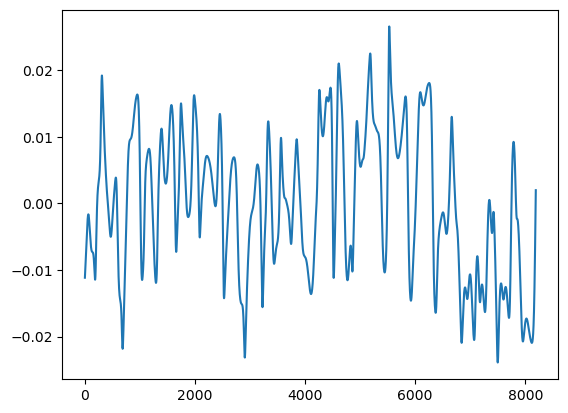

In [18]:
plt.plot(phi[:, 3])

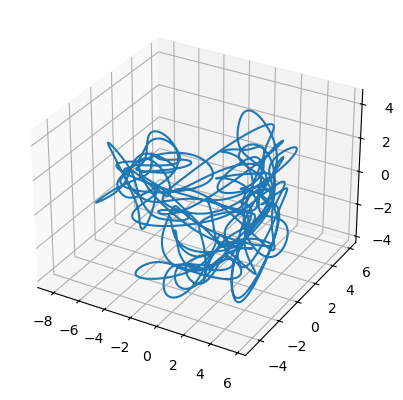

In [20]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# idx = [1, 2, 3]
idx = [1, 2, 3]

ax.plot(eig[idx[0]]*phi[:, idx[0]], eig[idx[1]]*phi[:, idx[1]], eig[idx[2]]*phi[:, idx[2]])

In [12]:
from sklearn.manifold import Isomap

Nm = 10000
K = int(np.sqrt(Nm))
isom = Isomap(n_neighbors=K, n_components=6)


dat = uu[:Nm]
X = isom.fit_transform(dat).T

In [13]:
X.shape

(6, 10000)

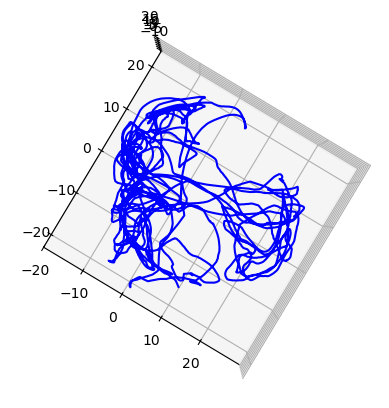

In [14]:
from matplotlib import pyplot as plt

f = plt.figure()
ax = plt.axes(projection="3d")
ax.plot(*X[:3], "b-")
ax.view_init(elev=90)